In [238]:
# for Data Manipulation
import pandas as pd
import numpy as np

# for Graphics
import matplotlib.pyplot as plt

# for ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# for Word Cloud
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Data Analysis

In [239]:
df = pd.read_csv("JEOPARDY_CSV.csv")

In [240]:
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [241]:
df.shape

(216930, 7)

In [242]:
for column in df.columns:
    print(column, len(df[column].unique()))

Show Number 3640
 Air Date 3640
 Round 4
 Category 27995
 Value 150
 Question 216124
 Answer 88269


In [243]:
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [244]:
df['year'] = pd.to_datetime(df[' Air Date']).dt.year

In [245]:
df.year.value_counts()

2008    14036
2007    13940
2010    13756
2006    13726
2009    13579
2005    13560
1999    13540
2000    13439
2011    13376
2004    13190
1998    13143
1997    13099
2001    12097
2003     9426
2002     6859
1996     4891
1990     4337
1993     2132
1989     2067
1992     1885
1991     1444
1986     1409
1988     1290
1987     1275
1984     1179
1995     1138
1994     1136
2012     1093
1985      888
Name: year, dtype: int64

In [246]:
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


## Too many years so we reduced to decade to avoid explosive combinatorics

In [247]:
df["decade"] = df.year//10*10

In [248]:
# there was some issue with the person who scraped the data; they left links in the data, so those were removed
df[" Question"].replace('<[^>]+>', '', regex=True, inplace=True)
list(df[" Question"])[29:45]

['Beyond ovoid abandonment, beyond ovoid betrayal... you won\'t believe the ending when he "Hatches the Egg"',
 'California',
 'It can be a place to leave your puppy when you take a trip, or a carrier for him that fits under an airplane seat',
 "He's considered the author of the Pentateuch, which is hard to believe, as Deuteronomy continues after his death",
 'Steven Tyler of this band lent his steamin\' vocals to "Train Kept A-Rollin\'", first popularized by the Yardbirds',
 'Around 100 A.D. Tacitus wrote a book on how this art of persuasive speaking had declined since Cicero',
 '1 of the 2 born in Vermont',
 "When it began on Pan Am & Qantas in the late '70s, it was basically a roped-off part of the economy cabin with free drinks",
 "Ali, who married this man's daughter Fatima, is considered by Shia Muslims to be his true successor",
 'During the 1954-1955 Sun sessions, Elvis climbed aboard this train "sixteen coaches long"',
 'The shorter glass seen here, or a quaint cocktail made w

# Machine Learning

In [281]:
n_features = 1000
n_components = 3
n_top_words = 1

def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, x=.5, y=1.2, fontsize=24)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Removing:
- Stop Words (common English words)
- Words occurring in only one document
- Words in 95% or more of the documents

In [282]:
%%time

data_samples = list(df[" Question"])#[:n_samples])
# data_samples = list(df["lemmas"][:n_samples]) # might have better results

CPU times: user 16.1 ms, sys: 528 µs, total: 16.6 ms
Wall time: 16.6 ms


# Sample NMF

## Use tf-idf features for NMF.


In [283]:
%%time

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)

CPU times: user 2.01 s, sys: 37.4 ms, total: 2.05 s
Wall time: 2.05 s


## Fit the NMF model

In [284]:
%%time 

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

CPU times: user 8.35 s, sys: 436 ms, total: 8.79 s
Wall time: 5.15 s


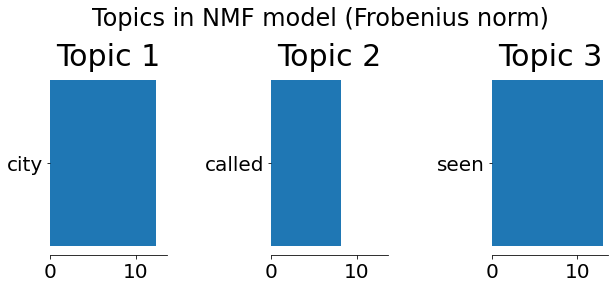

CPU times: user 425 ms, sys: 87.5 ms, total: 512 ms
Wall time: 133 ms


In [285]:
%%time

plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Sample LDA

## Use tf (raw term count) features for LDA.


In [286]:
%%time

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)

CPU times: user 1.97 s, sys: 39.5 ms, total: 2.01 s
Wall time: 2.01 s


In [287]:
%%time

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

CPU times: user 1min 5s, sys: 245 ms, total: 1min 5s
Wall time: 1min 5s


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=3, random_state=0)

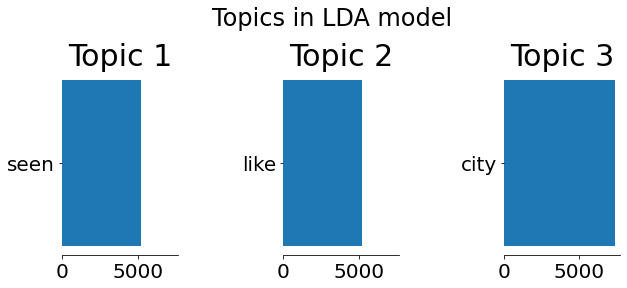

CPU times: user 121 ms, sys: 3.73 ms, total: 125 ms
Wall time: 123 ms


In [288]:
%%time

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

## Since there was no large difference between the global analysis, we'll use NMF for all analysis moving forward.

# Question 1

In [28]:
df = pd.read_csv("JEOPARDY_CSV.csv")
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [29]:
df[" Question"].replace('<[^>]+>', '', regex=True, inplace=True)

In [30]:
df['year'] = pd.to_datetime(df[' Air Date']).dt.year
df["decade"] = df.year//10*10

In [31]:
df = df.sort_values(by='year')

In [32]:
np.unique(df['year'].values)

array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=int64)

In [33]:
# Subset the dataframe by year
df_by_year = [pd.DataFrame(y) for x, y in df.groupby('year', as_index=False)]

In [35]:
topic_split = [pd.DataFrame(y) for blah in df_by_year for x, y in blah.groupby(' Round', as_index=False)]

In [36]:
#n_samples = 100_000
n_features = 1000
n_components = 5
n_top_words = 1

def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 5), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        
#         ax.set_title(f'Topic {topic_idx + 1}',
#                      fontdict={'fontsize': 30})
        
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=24)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [37]:
len(topic_split)

90

## Question 1 A

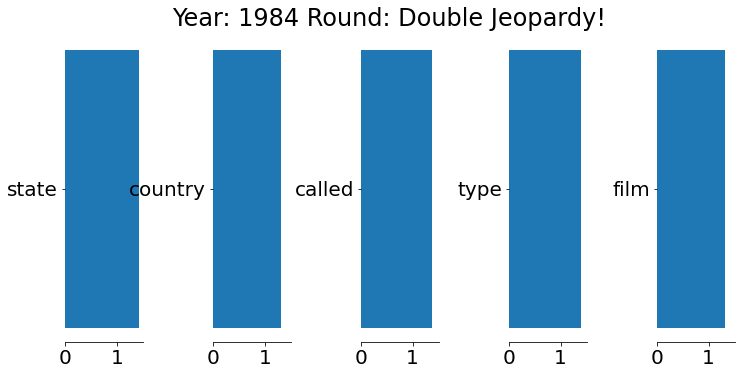

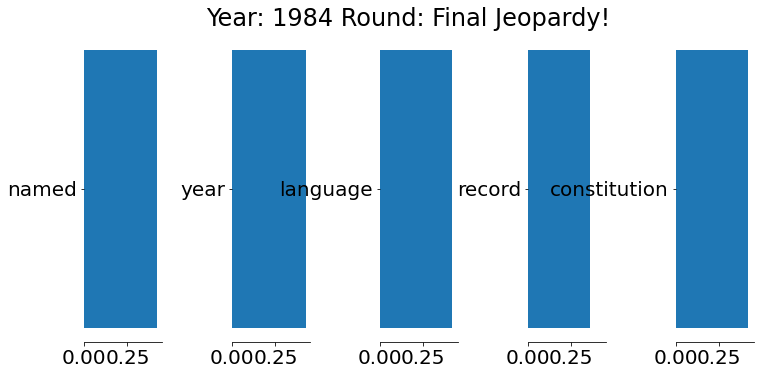

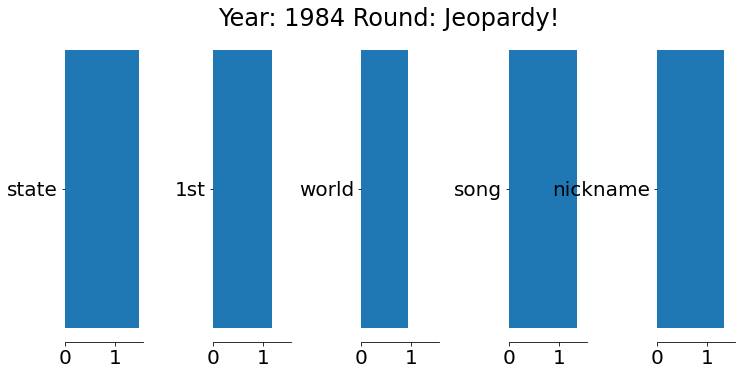

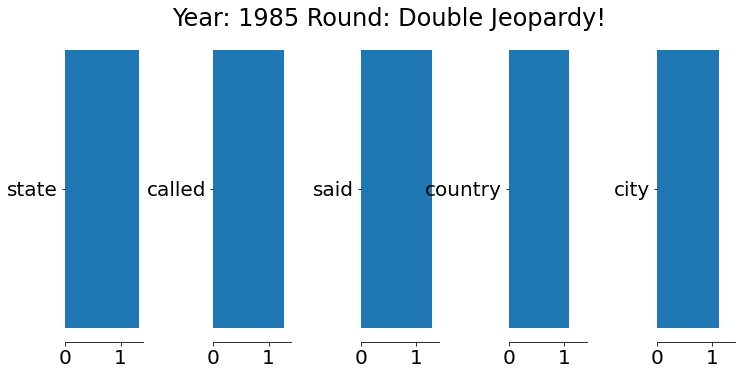

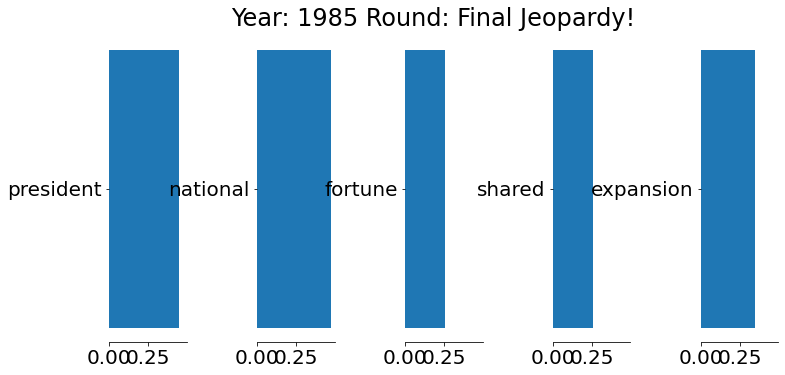

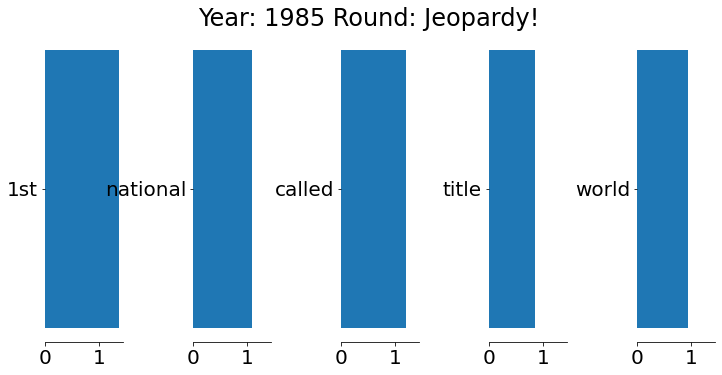

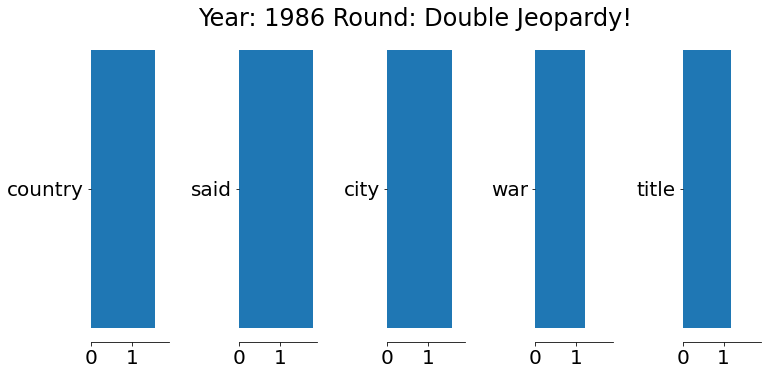

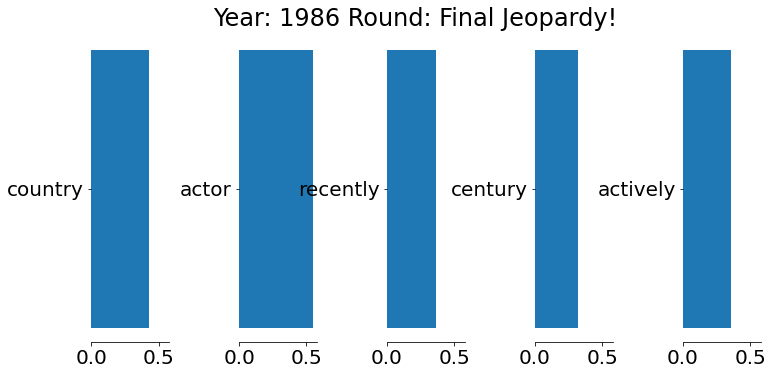

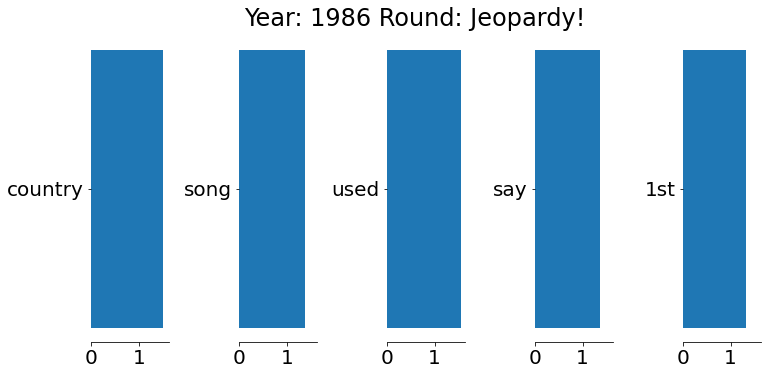

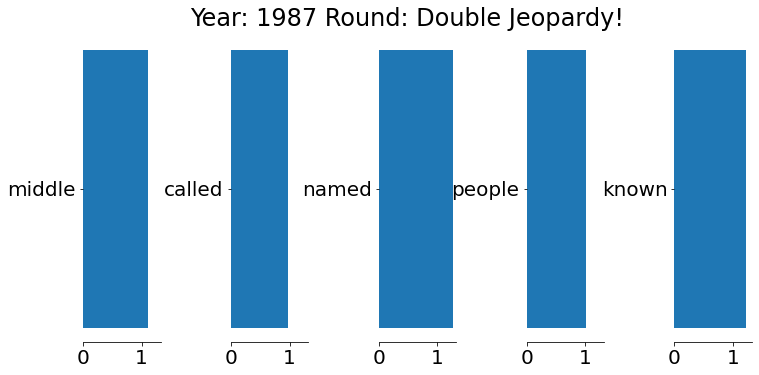

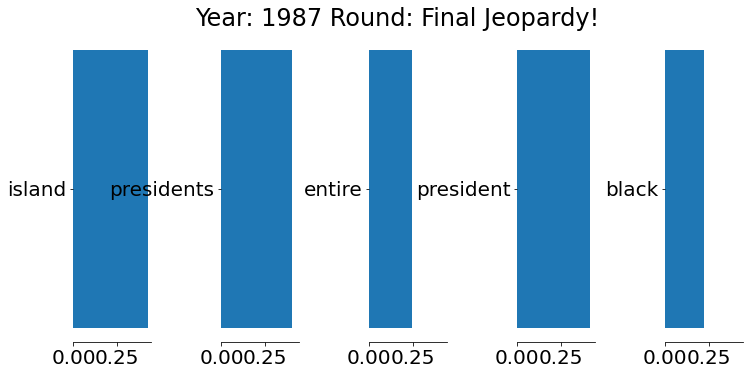

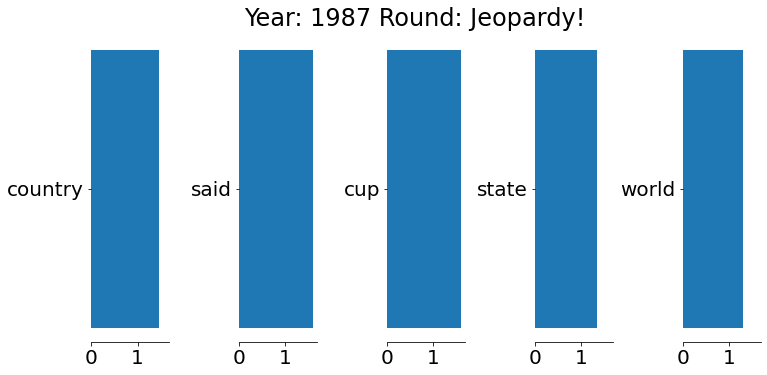

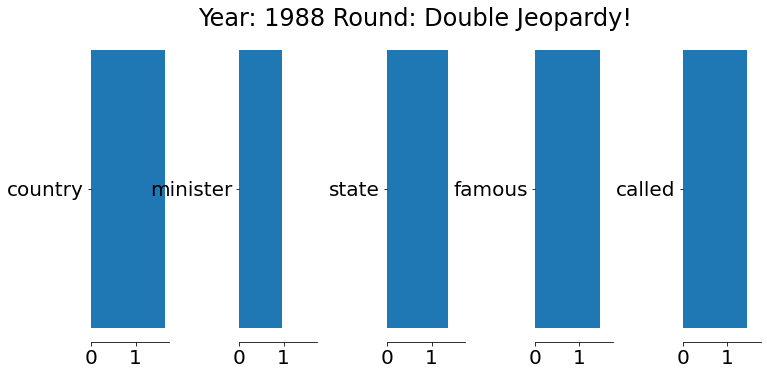

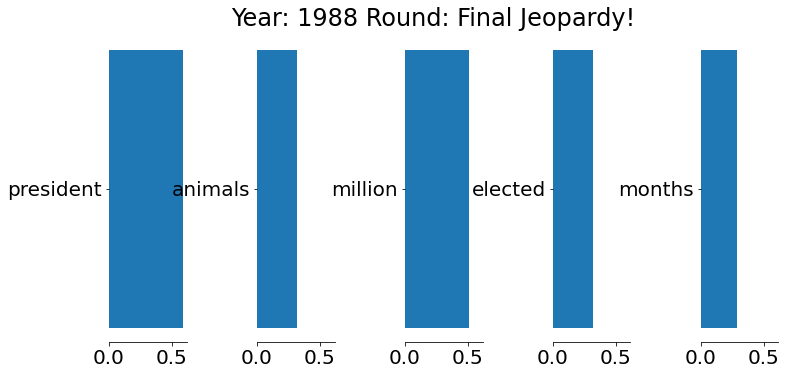

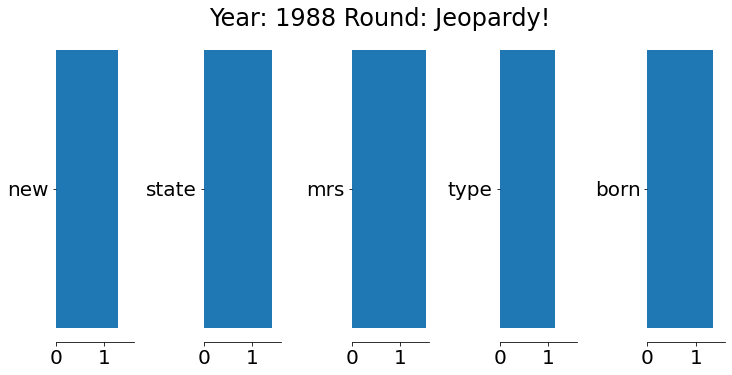

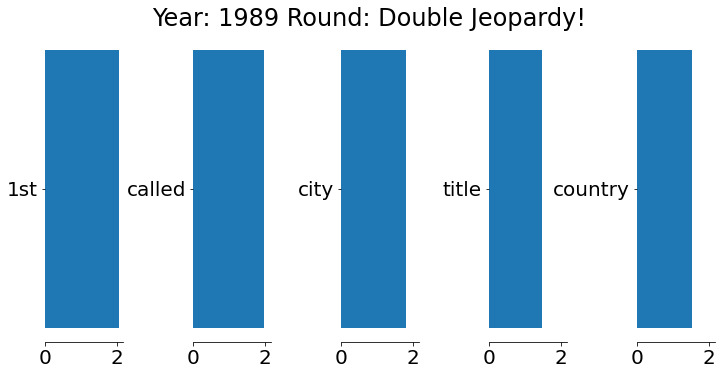

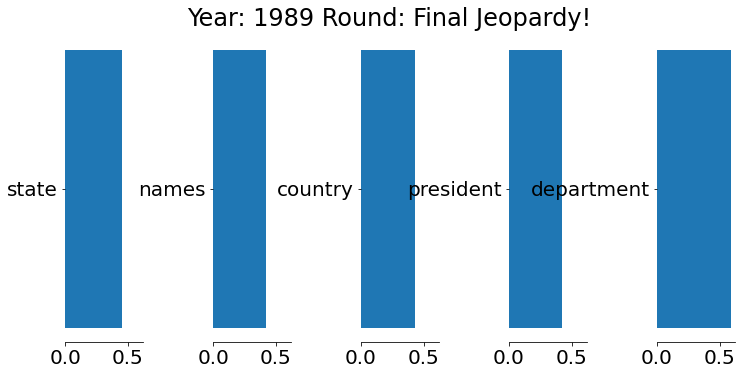

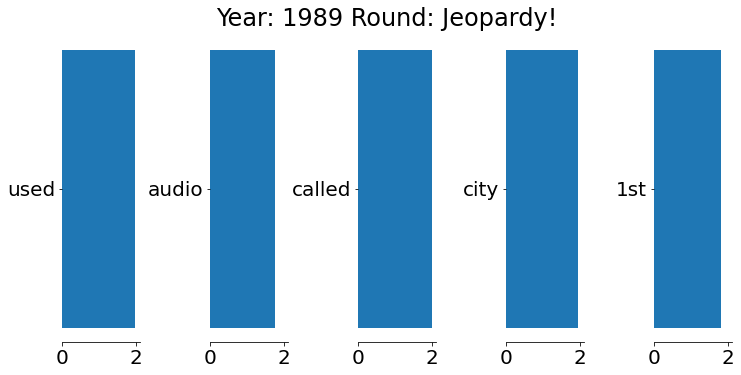

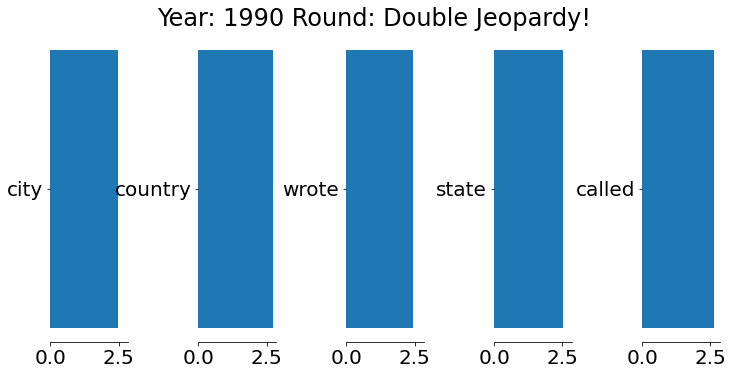

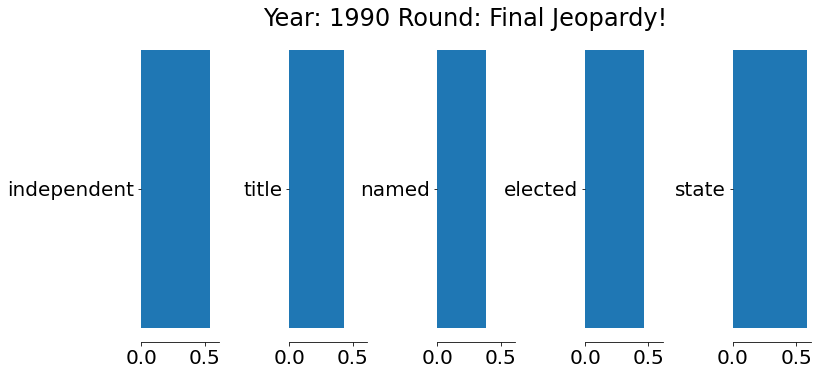

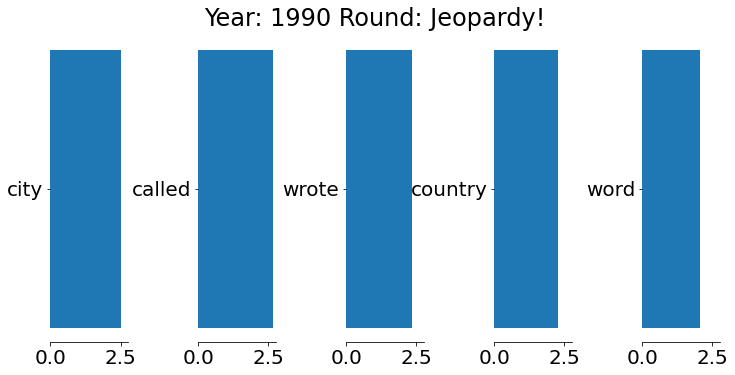

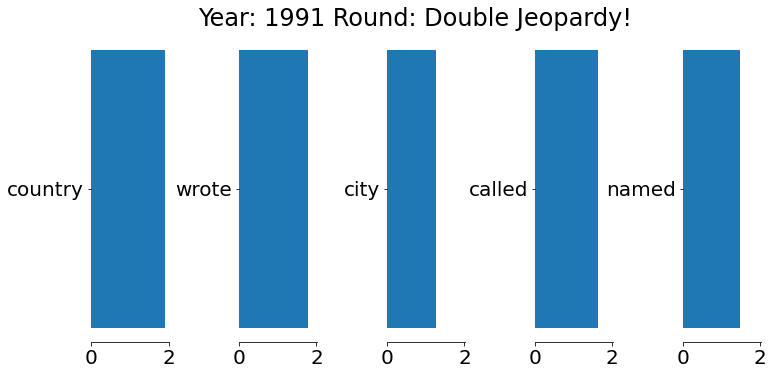

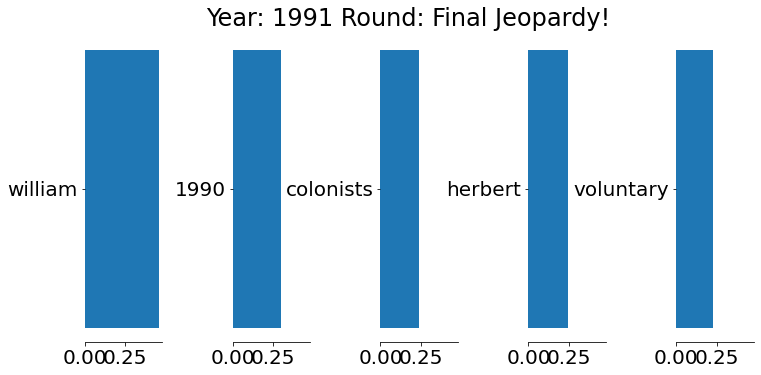

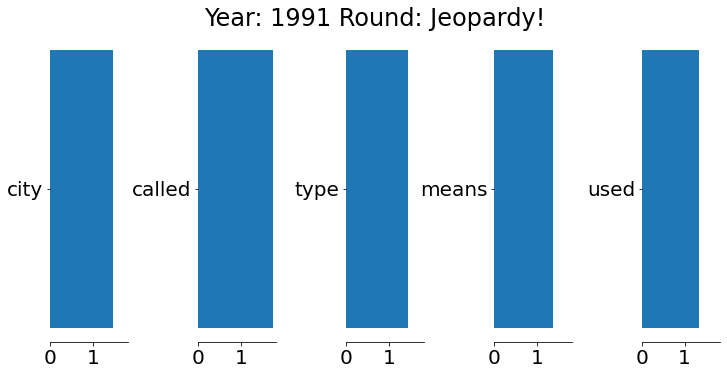

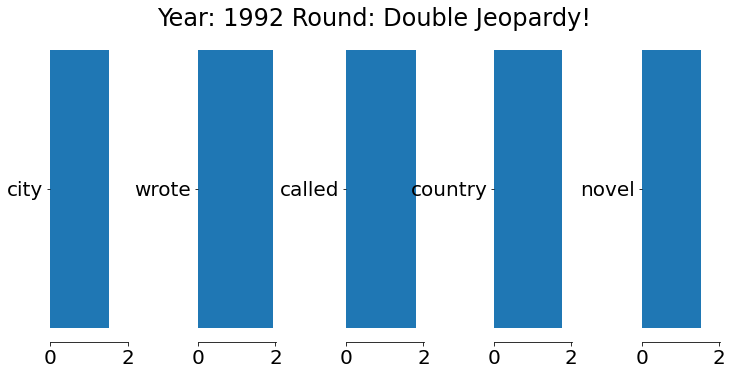

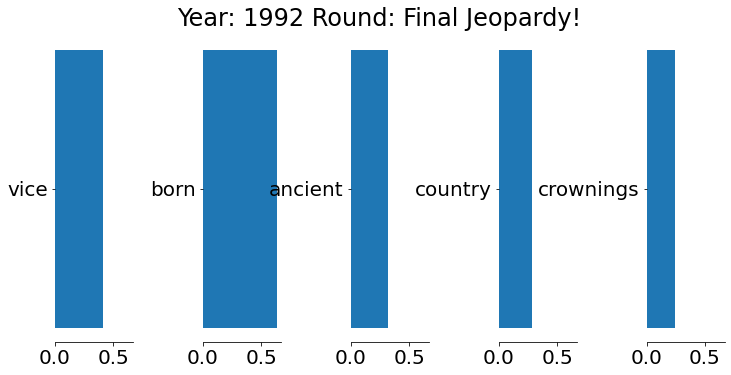

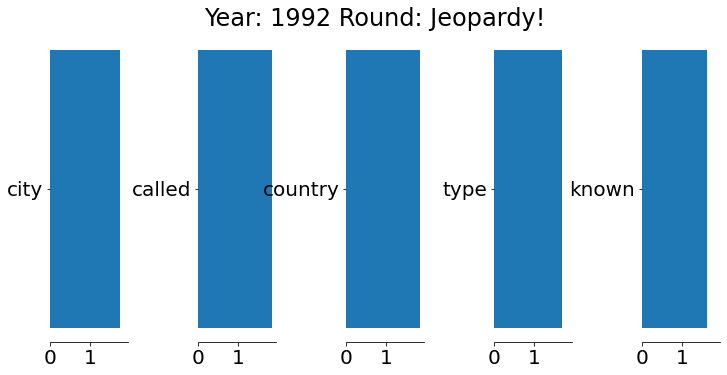

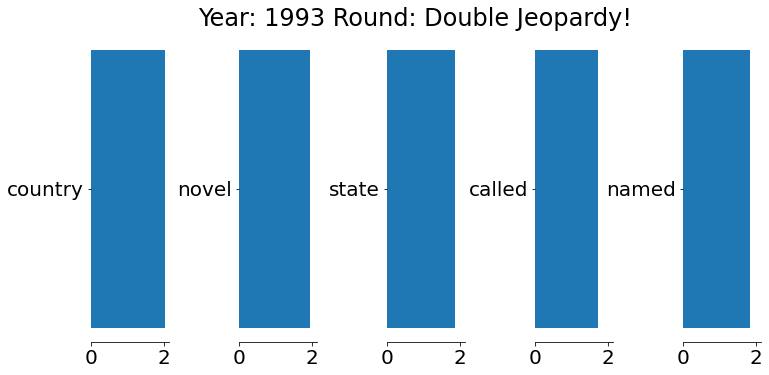

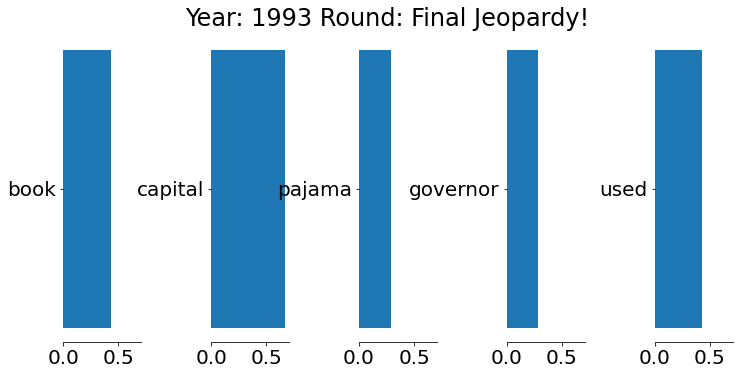

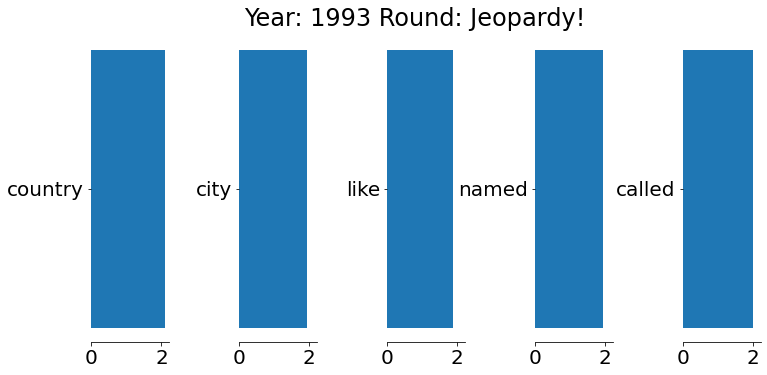

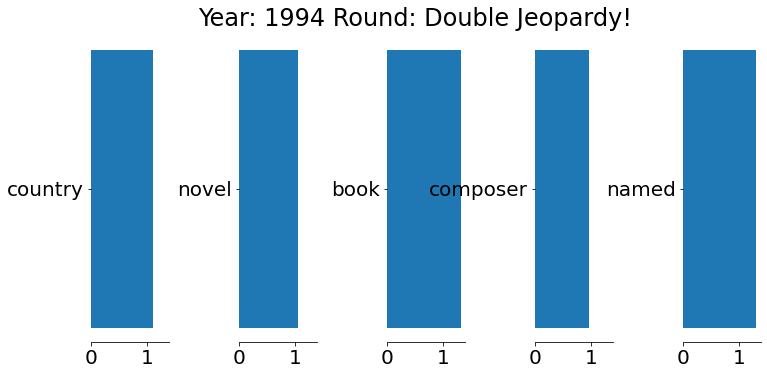

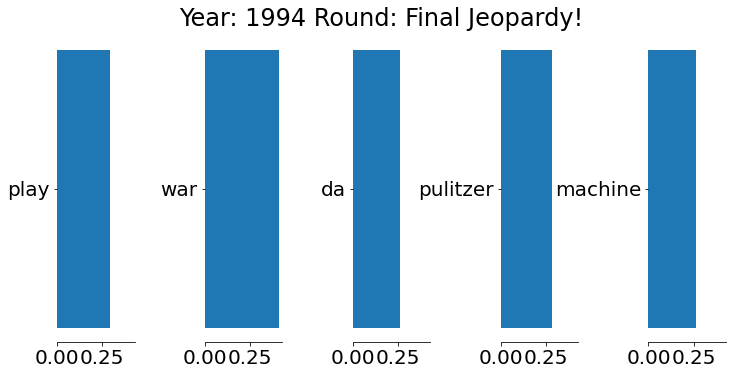

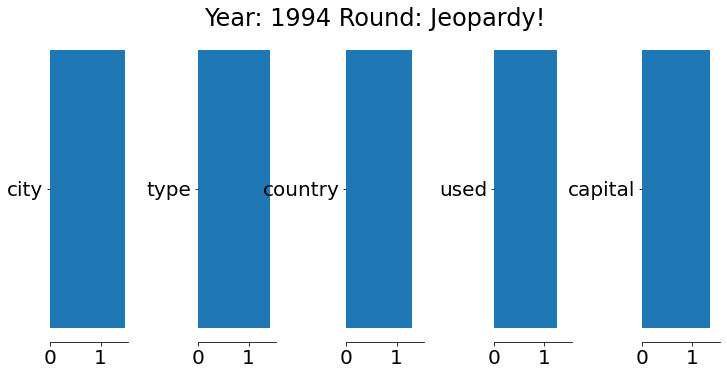

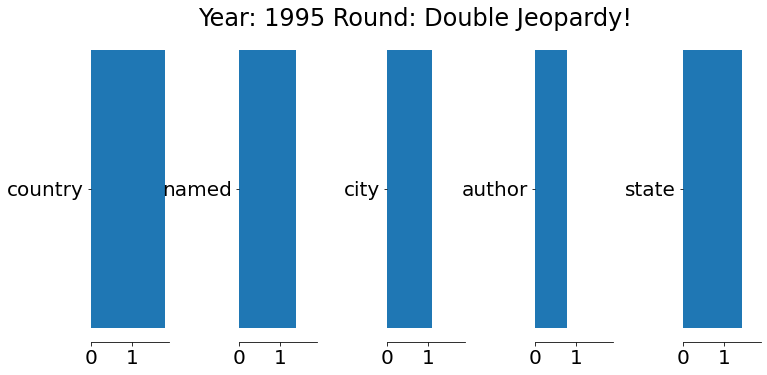

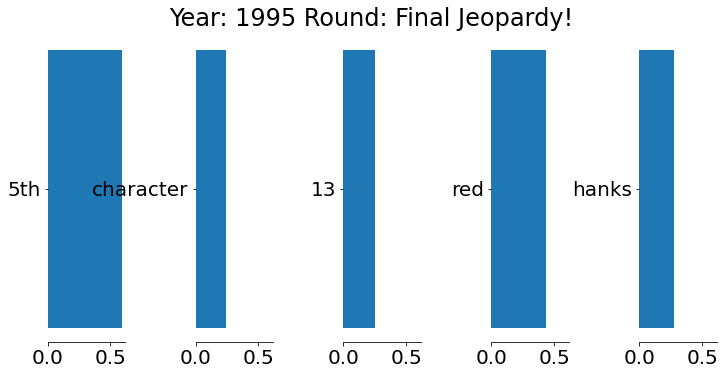

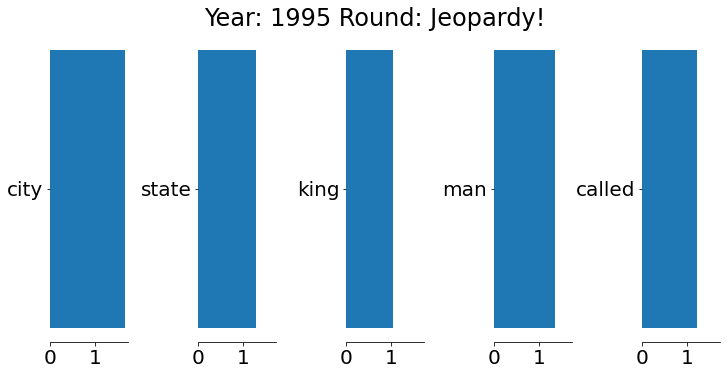

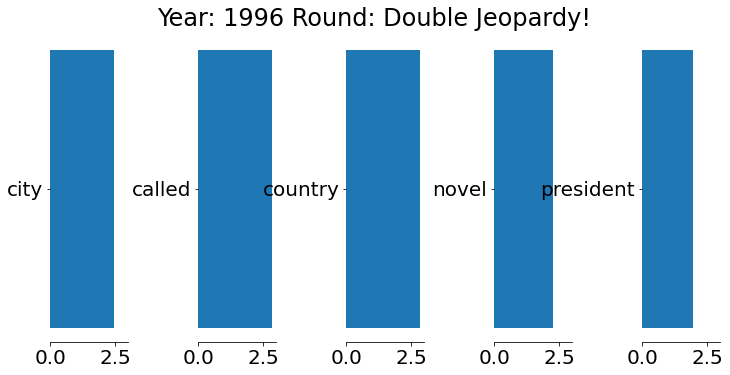

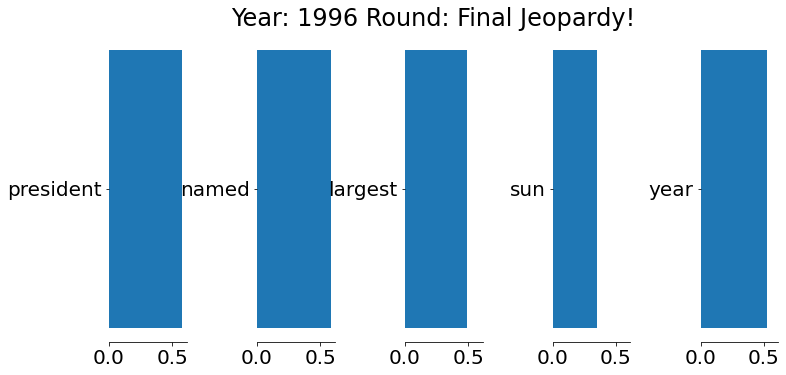

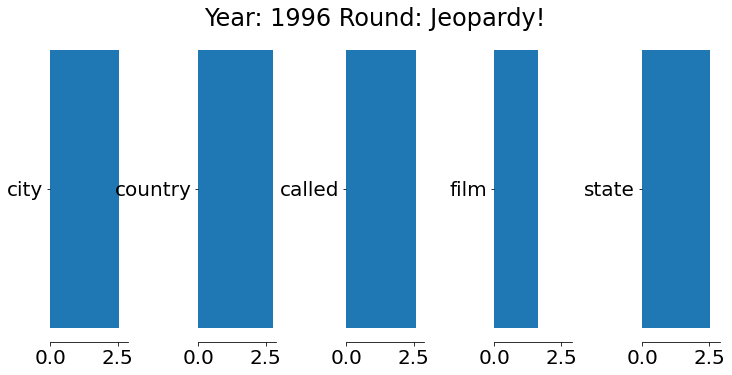

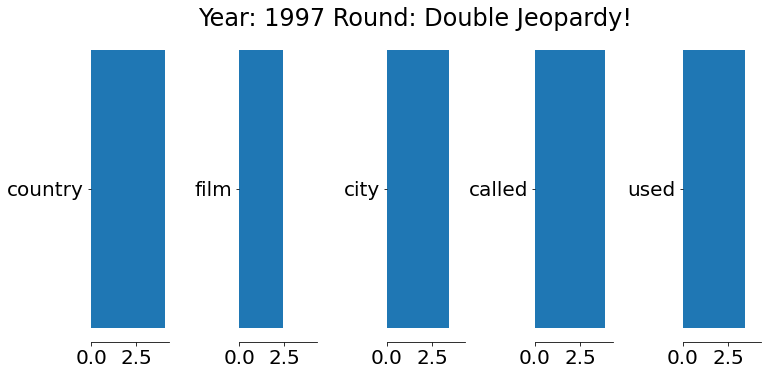

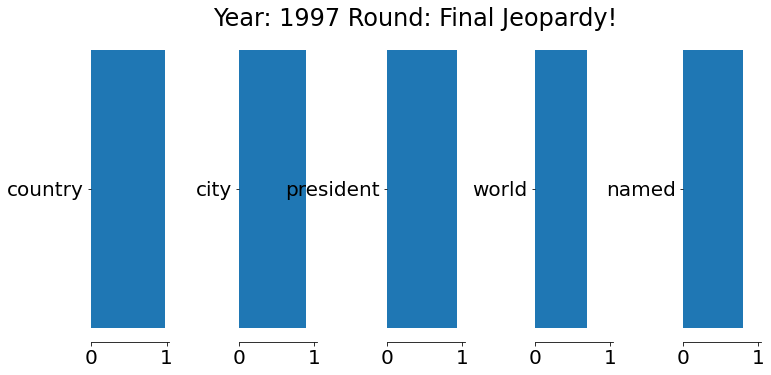

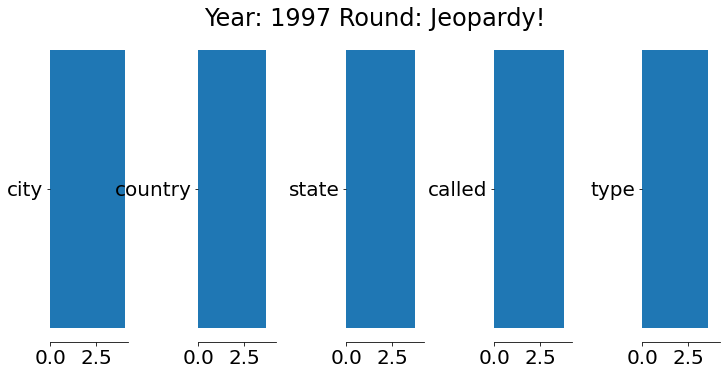

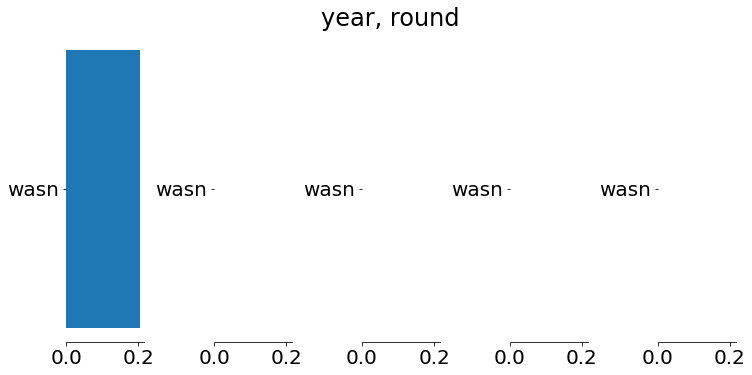

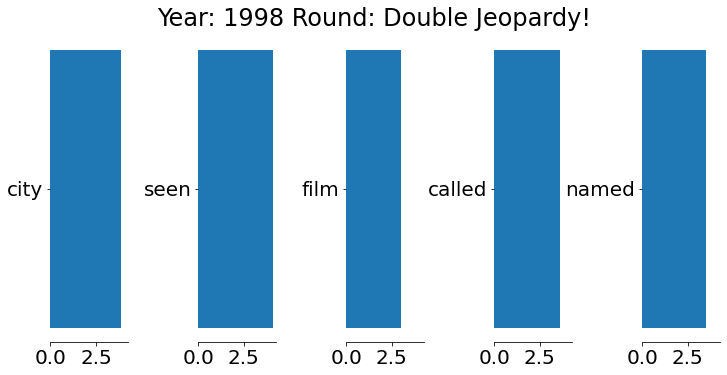

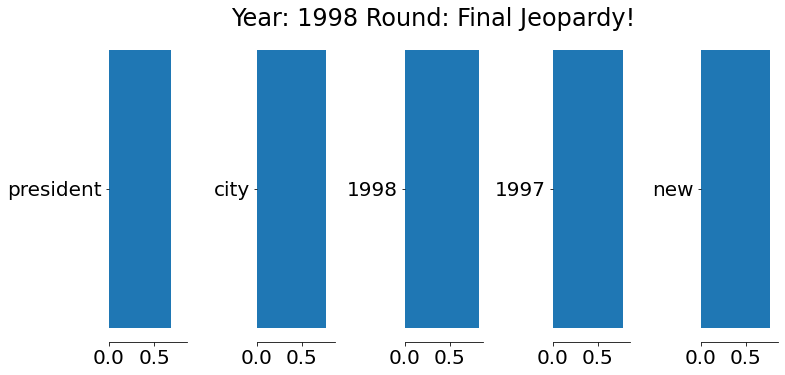

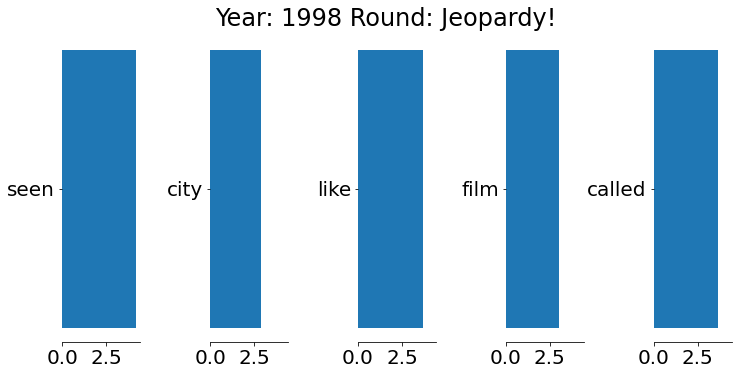

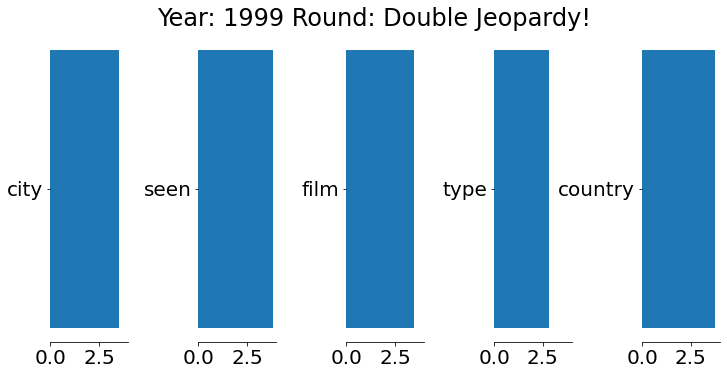

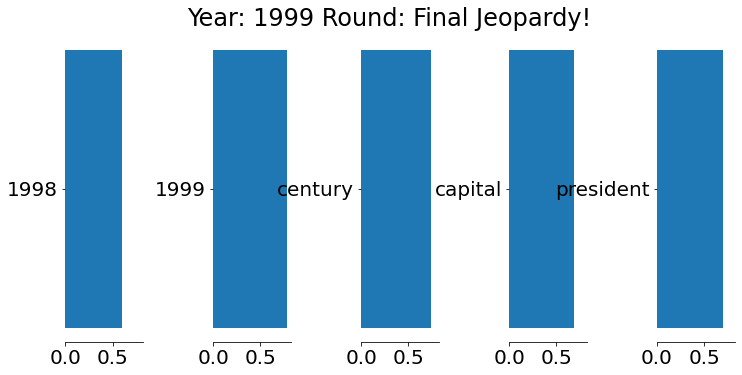

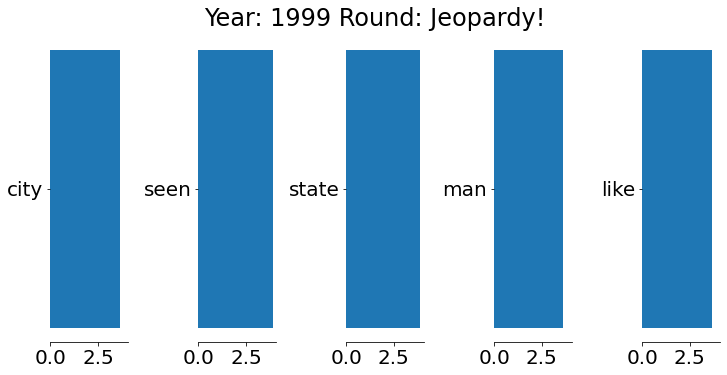

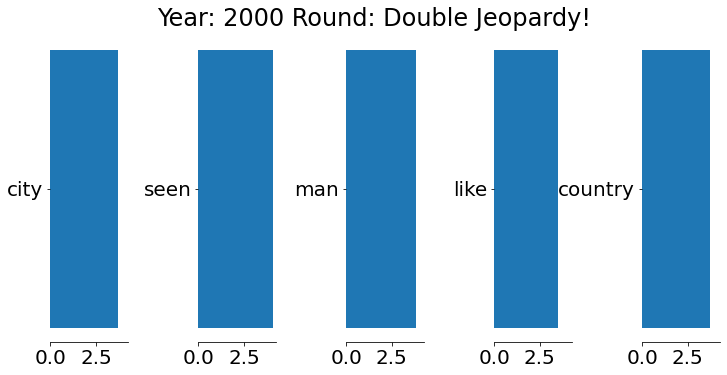

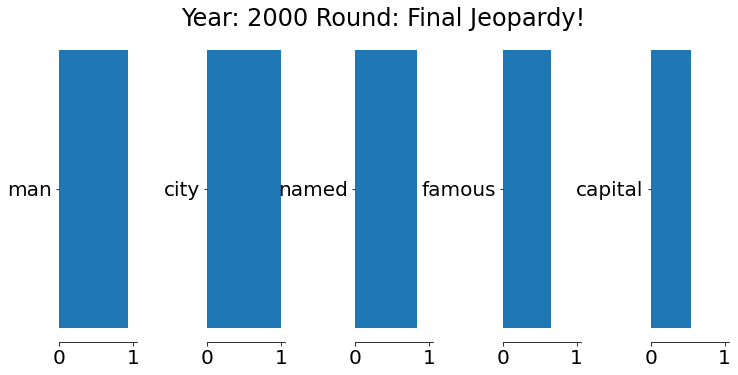

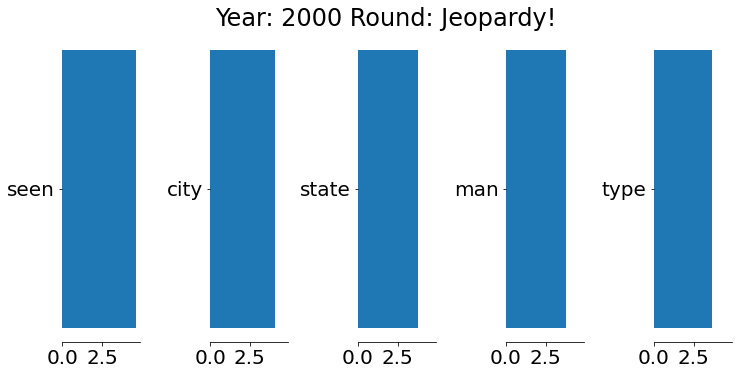

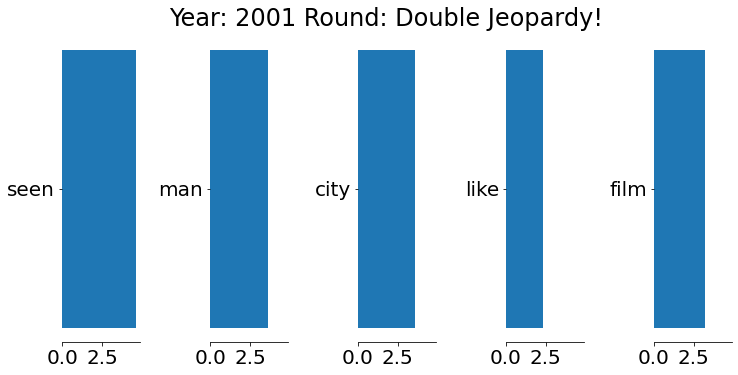

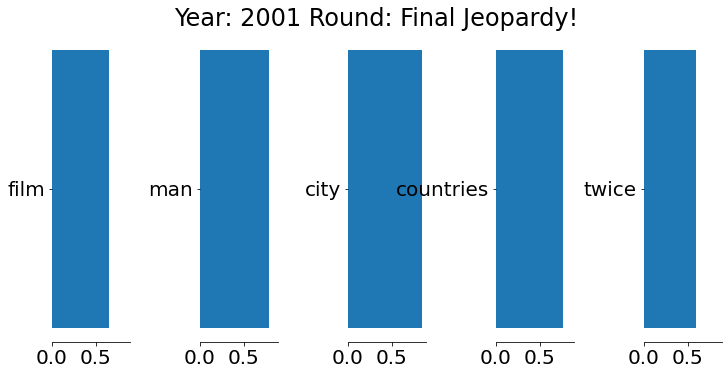

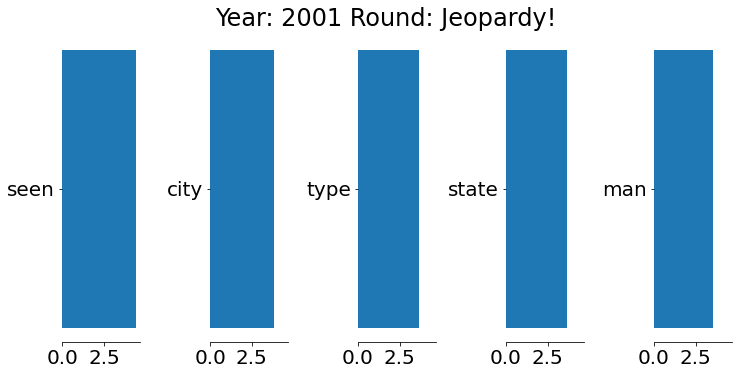

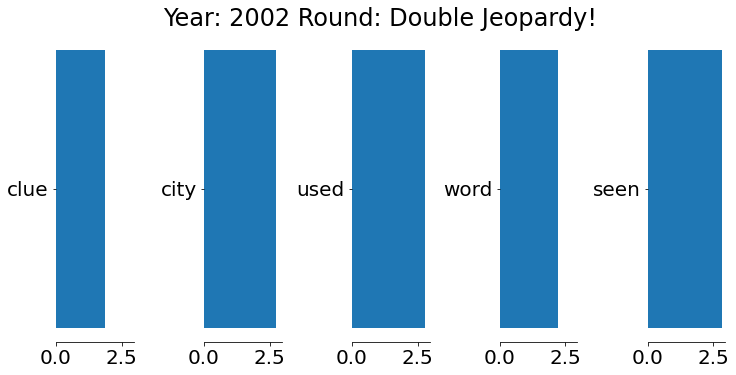

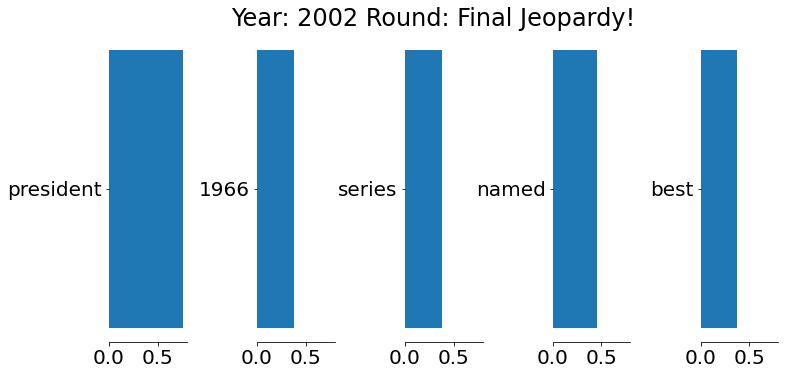

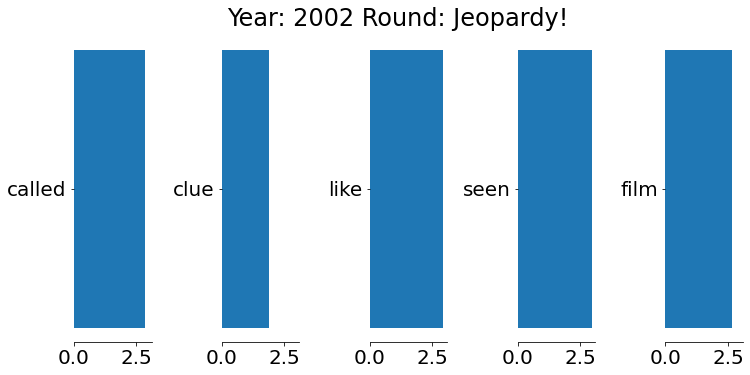

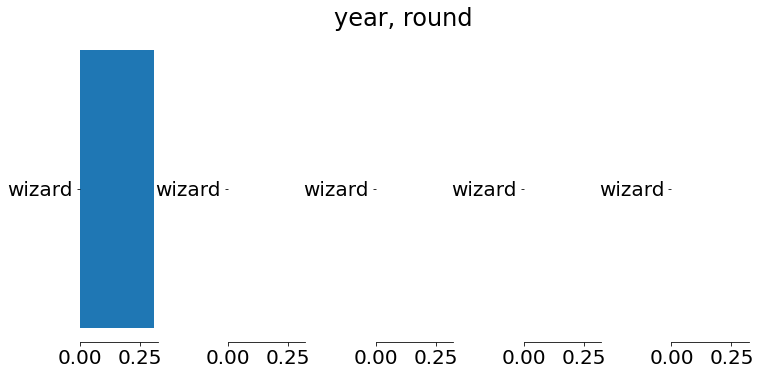

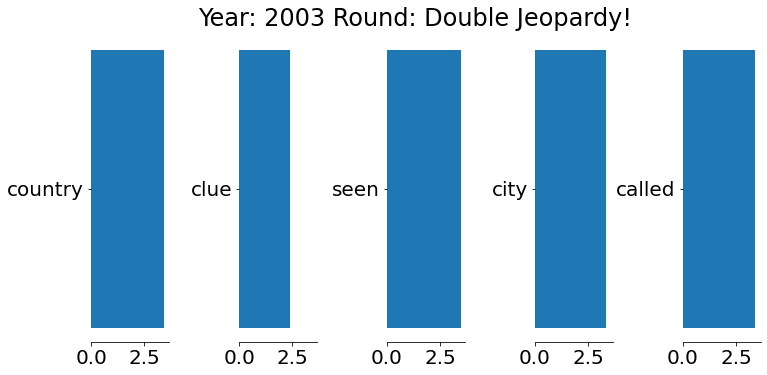

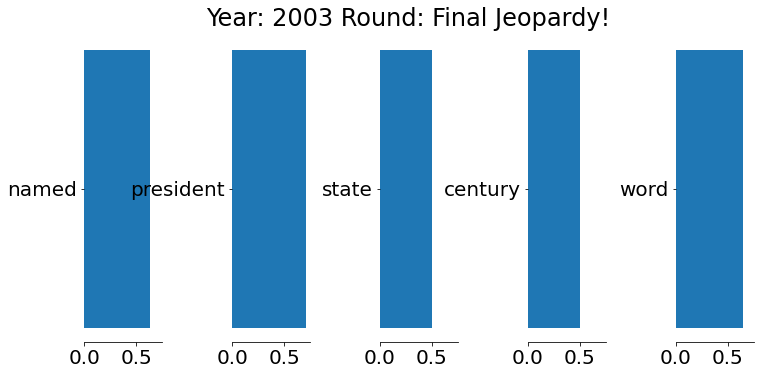

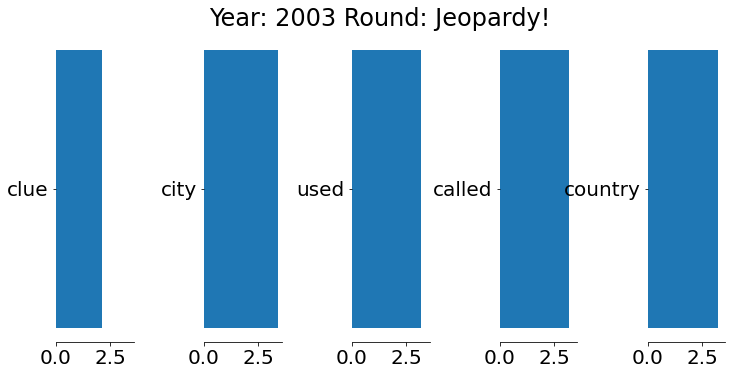

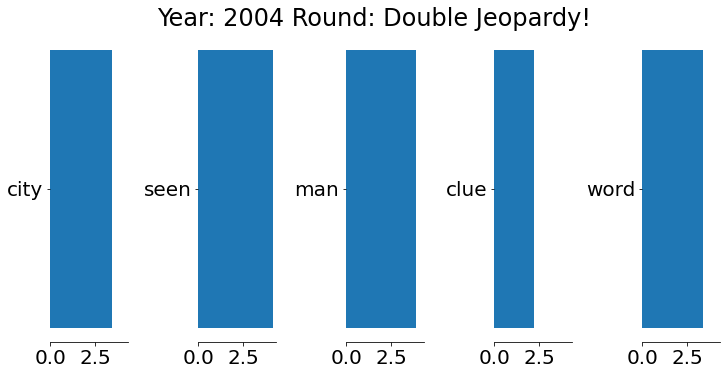

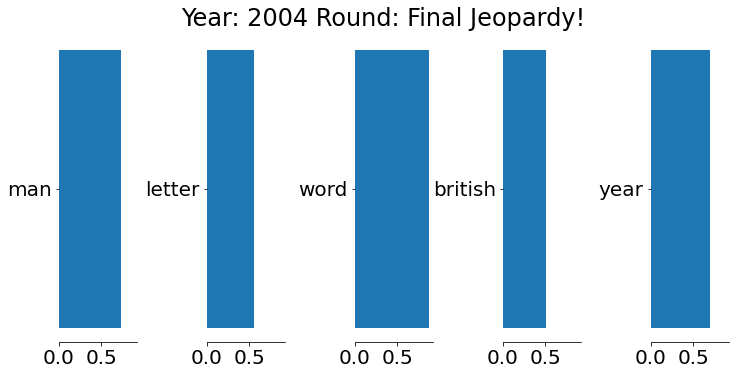

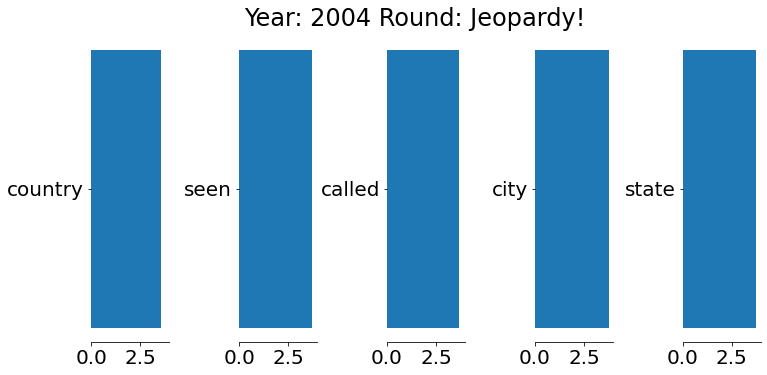

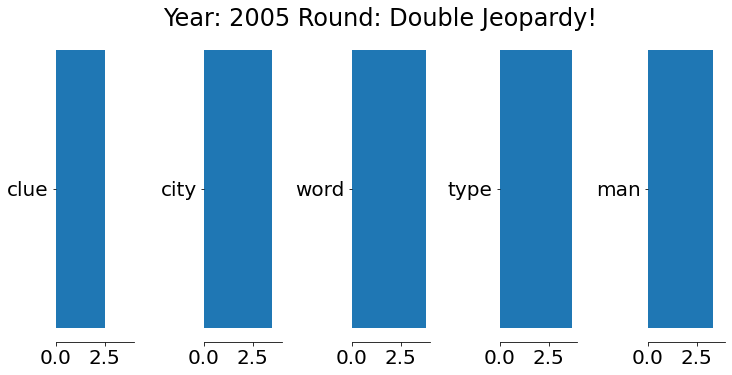

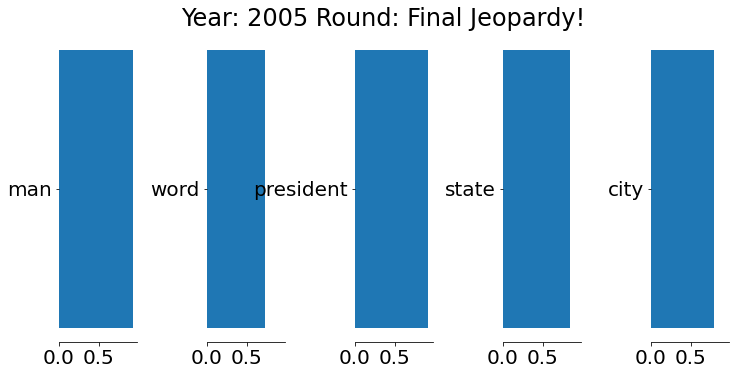

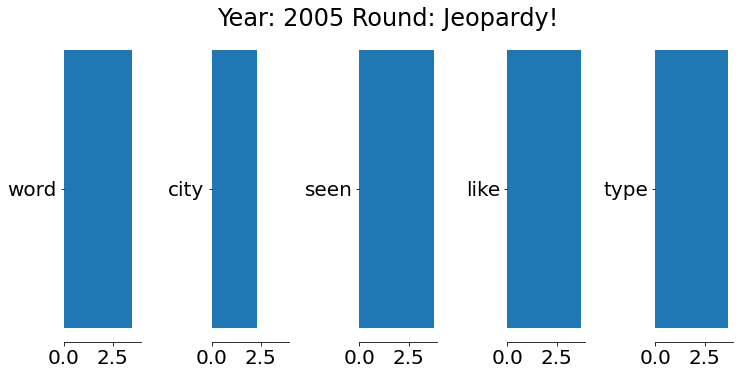

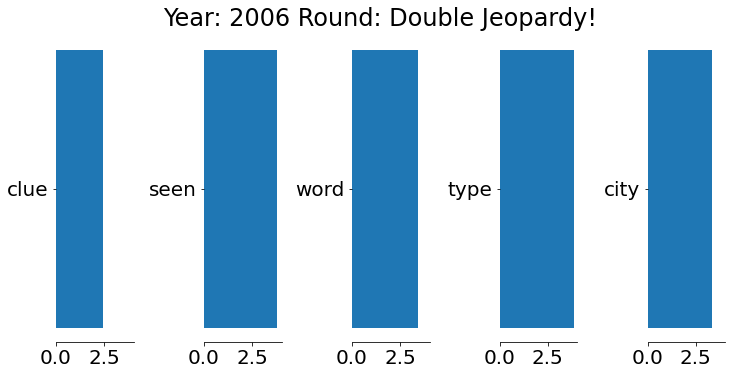

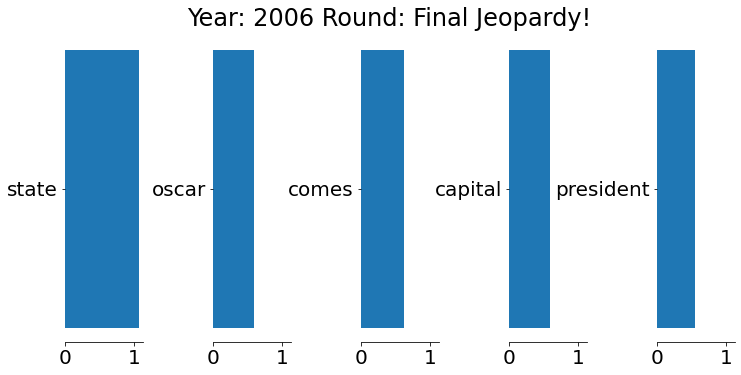

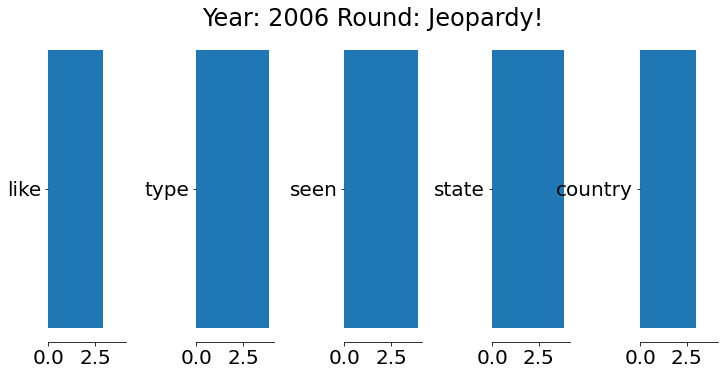

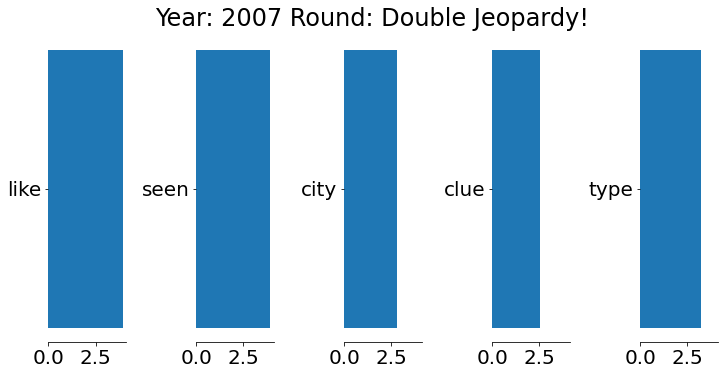

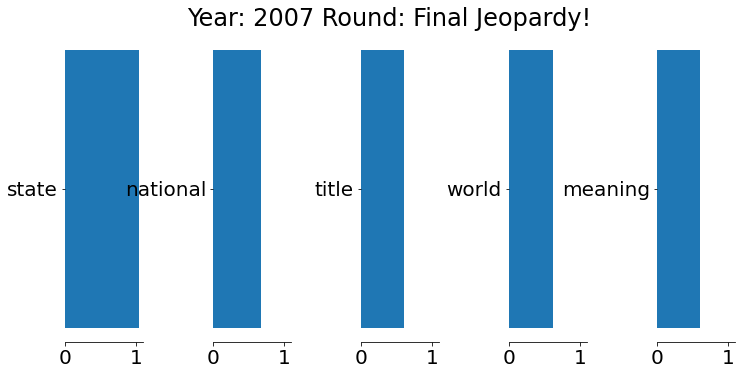

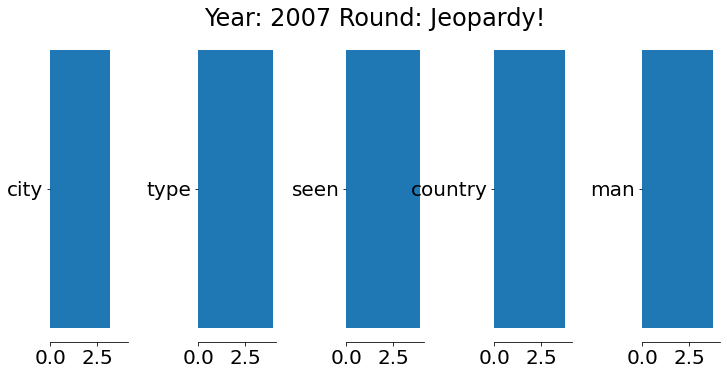

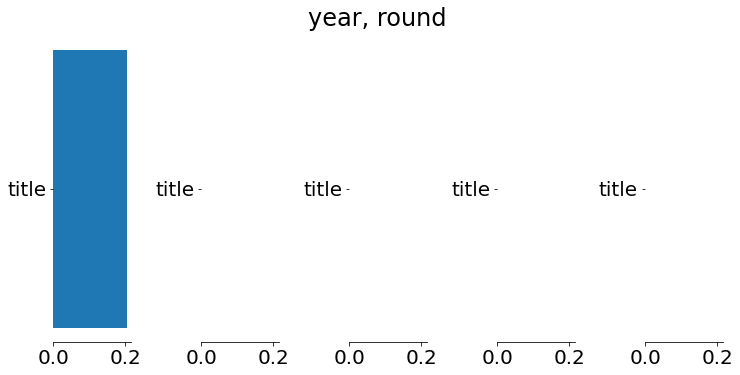

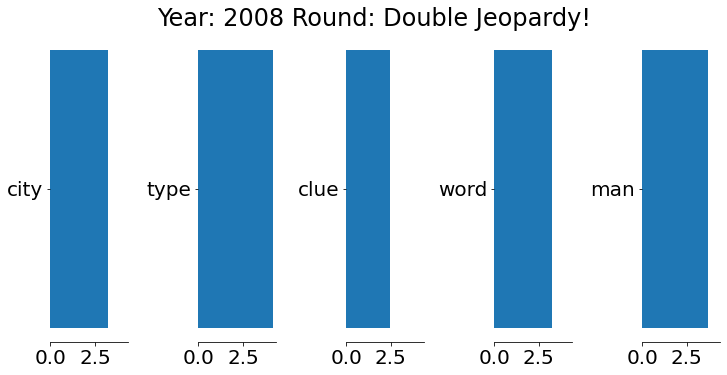

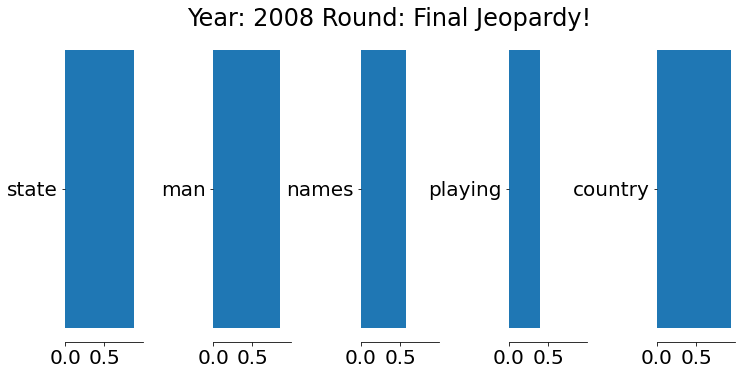

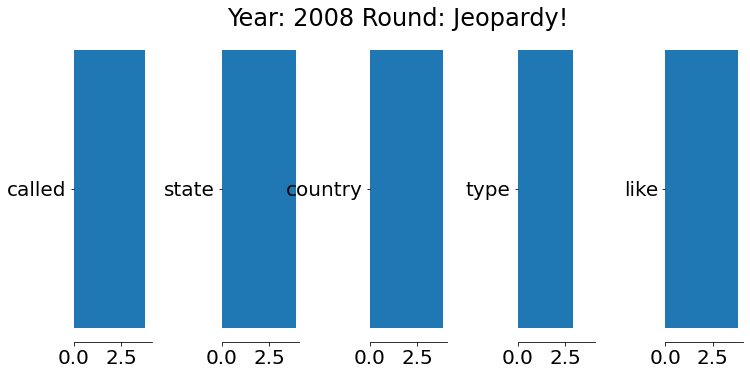

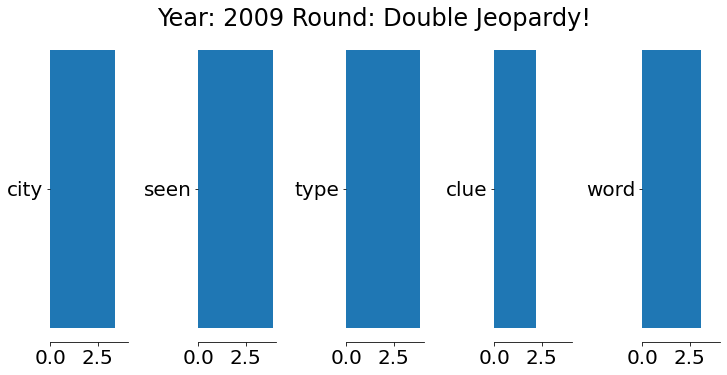

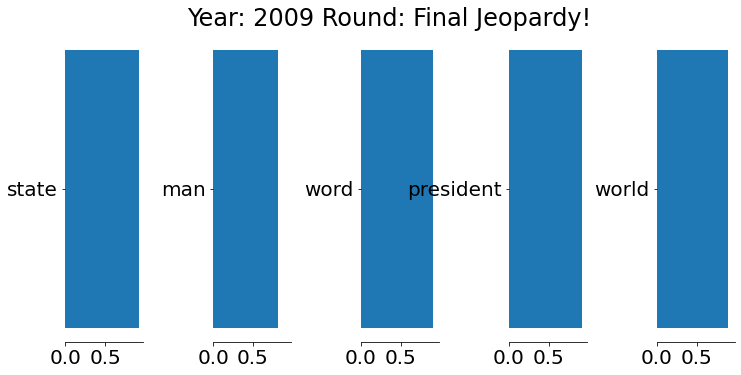

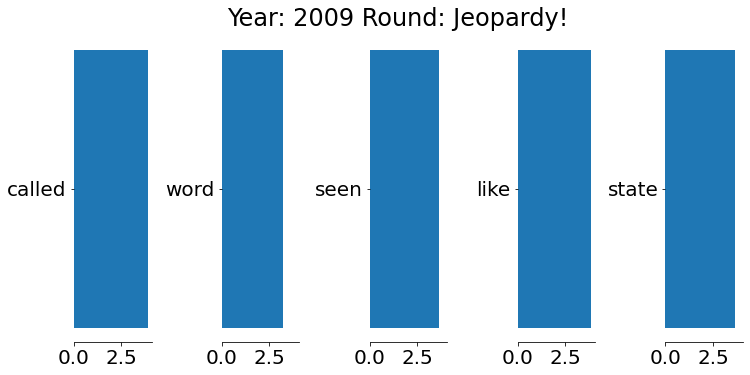

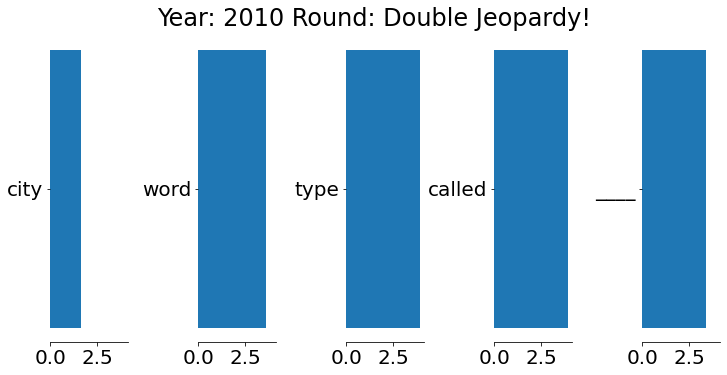

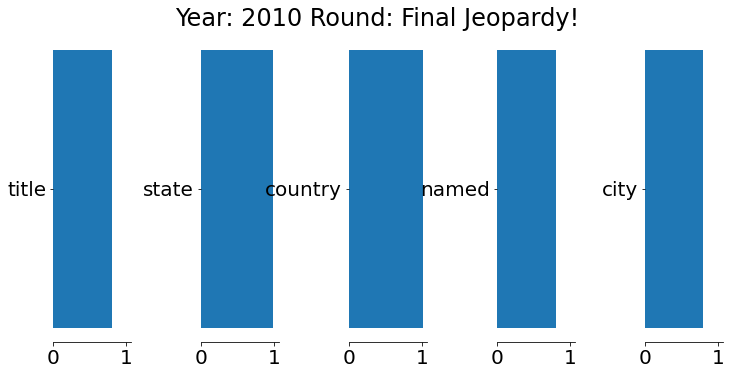

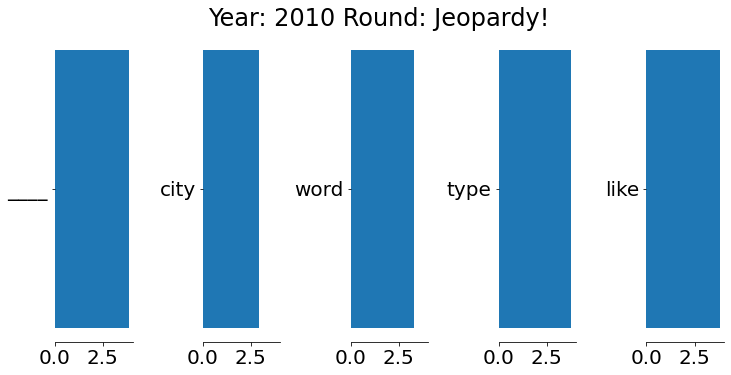

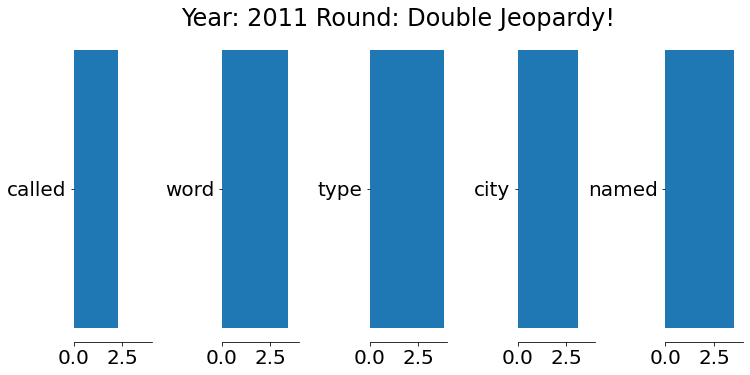

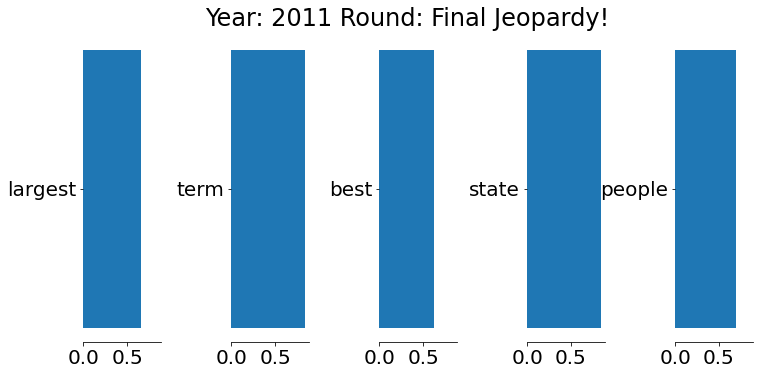

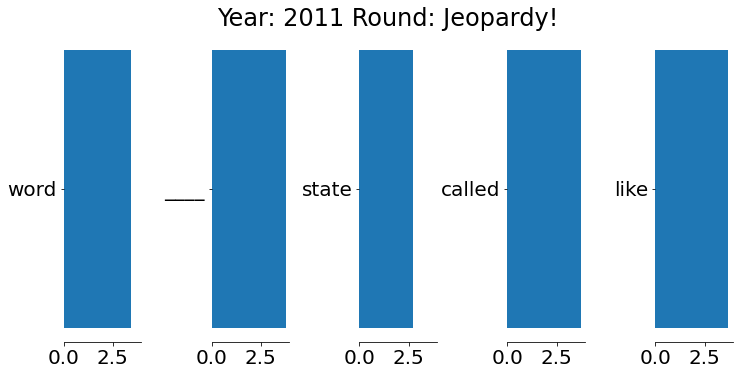

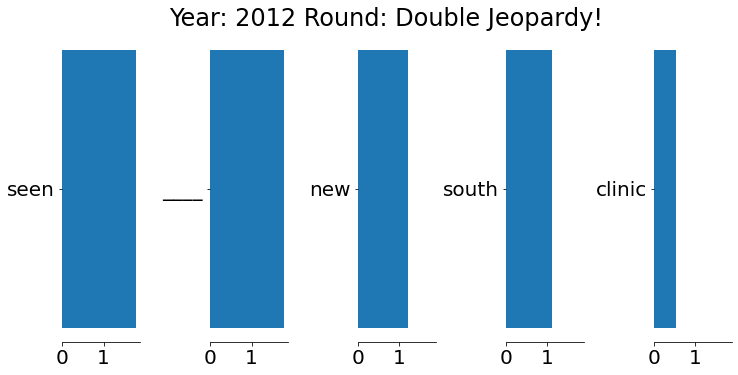

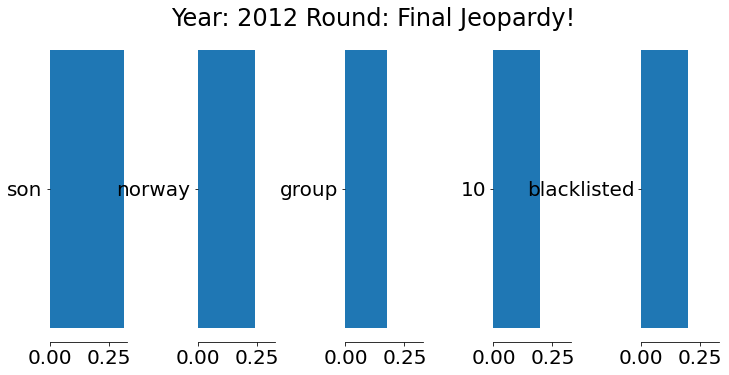

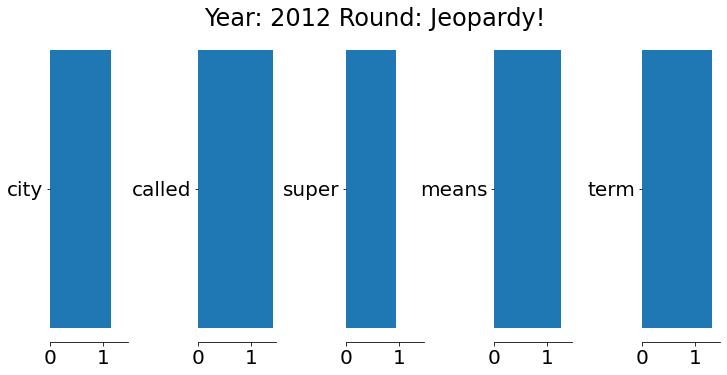

In [38]:
for i in range(len(topic_split)):


    data_samples = list(topic_split[i][" Question"])
    tfidf_vectorizer = TfidfVectorizer(
                                       max_features=n_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    try:
        plot_top_words(nmf, tfidf_feature_names, n_top_words,
                   f'Year: {topic_split[i].iloc[1,-2]} Round: {topic_split[i].iloc[0,2]}')   # changed to index -2 after adding "decade" column

    except: 
        plot_top_words(nmf, tfidf_feature_names, n_top_words,'year, round')
        


**We chose top 5 topics to get a better sense of what was being asked. With just 1 or 2 top topics, there isn’t enough data to make a solid conclusion on changes in themes throughout the year. Top 5 also takes care of the off-chance that a random word that got through our defined stopwords makes it into the graph. We break down the original data frame by year, and for each year we further break down the dataframe by Jeopardy rounds. As a result, we have 90 sets of NMF identified topic results.**

## Question 1 B

In [39]:
np.unique(df['decade'].values)

array([1980, 1990, 2000, 2010], dtype=int64)

In [40]:
np.unique(df['year'].values)

array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=int64)

#### We split the dataframe by decade, so it will break into 1980s, 1990s, 2000s, 2010. We will analyze the the topics over decades. For each decade, we calculated the proportion of questions with each identified top theme. We looked at the top 5 topics and compared how they change from decade to decade.

In [41]:
# Subset the dataframe by year
df_by_decade = [pd.DataFrame(y) for x, y in df.groupby('decade', as_index=False)]
topic_split_decade = [pd.DataFrame(y) for blah in df_by_decade for x, y in blah.groupby(' Round', as_index=False)]

In [42]:
len(topic_split_decade)

14

###  Top five topics for the four decades respectively

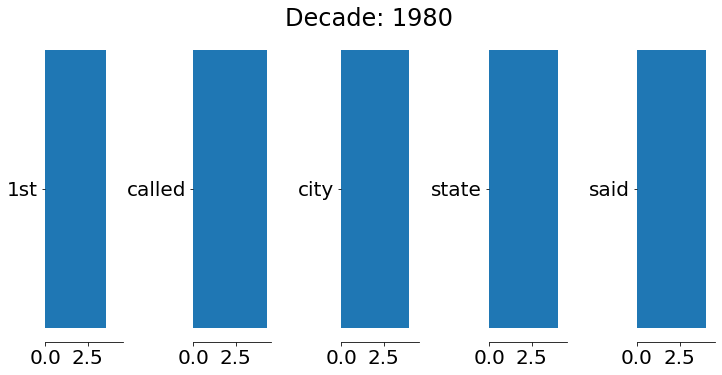

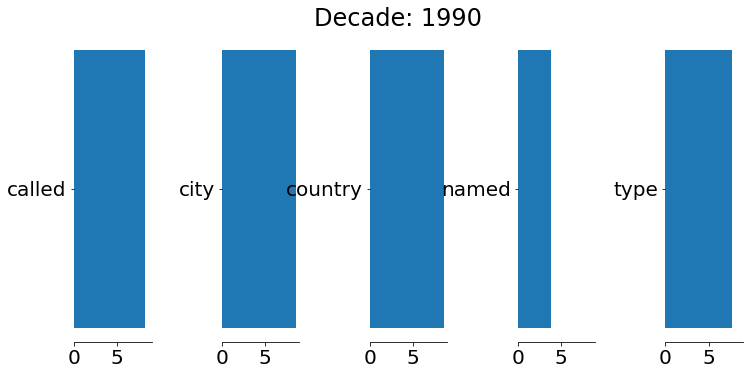

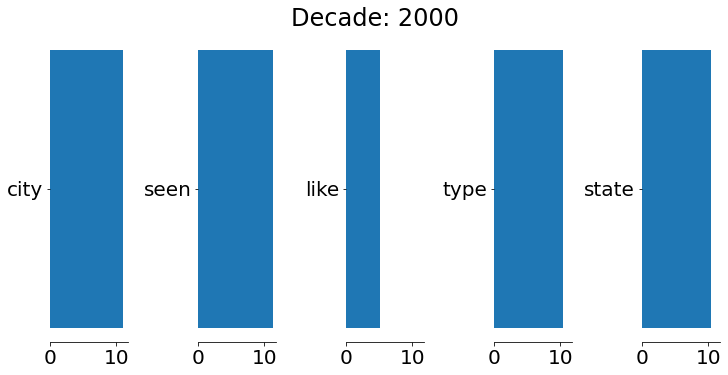

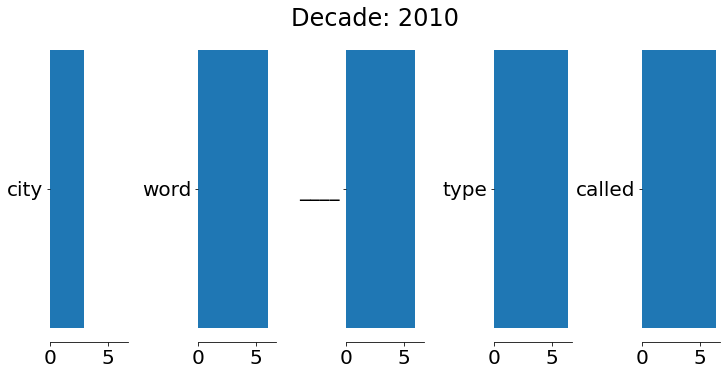

In [43]:
for i in range(len(df_by_decade)):


    data_samples = list(df_by_decade[i][" Question"])
    tfidf_vectorizer = TfidfVectorizer(
                                       max_features=n_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    try:
        plot_top_words(nmf, tfidf_feature_names, n_top_words,
                   f'Decade: {df_by_decade[i].iloc[1,-1]}')

    except: 
        plot_top_words(nmf, tfidf_feature_names, n_top_words,'Decade, round')
        


#### Decade 1980s - Top 5 topics identified: 1st, called, city, state, said

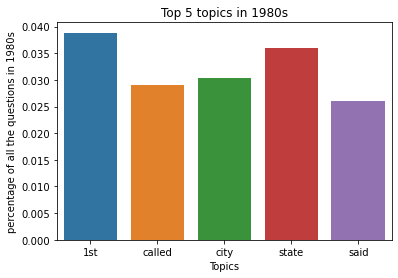

In [44]:
df_1980s = df[df['decade']==1980]
df_1980s[' Question']=df_1980s[' Question'].str.lower()

# questions that contains the word '1st'
df_1980s_1st = df_1980s[df_1980s[' Question'].str.contains("1st")]


# questions that contains the word 'called'
df_1980s_called = df_1980s[df_1980s[' Question'].str.contains("called")]

# questions that contains the word 'city'
df_1980s_city = df_1980s[df_1980s[' Question'].str.contains("city")]

# questions that contains the word 'state'
df_1980s_state = df_1980s[df_1980s[' Question'].str.contains("state")]

# questions that contains the word 'said'
df_1980s_said = df_1980s[df_1980s[' Question'].str.contains('said')]

# Plot the percentages of questions from each top topics 
percent_1st_1980s=len(df_1980s_1st)/len(df_1980s)

percent_called_1980s = len(df_1980s_called)/len(df_1980s)

percent_city_1980s = len(df_1980s_city)/len(df_1980s)

percent_state_1980s = len(df_1980s_state)/len(df_1980s)

percent_said_1980s = len(df_1980s_said)/len(df_1980s)

percent_topics__list_1980s = [percent_1st_1980s, percent_called_1980s, percent_city_1980s, percent_state_1980s,
                             percent_said_1980s]

topic_list = ['1st','called','city','state','said']

ax = sns.barplot(x=topic_list, y =percent_topics__list_1980s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 1980s',title='Top 5 topics in 1980s')
plt.show()


#### Decade 1990s - Top 5 topics identified: called, city, country, named, type

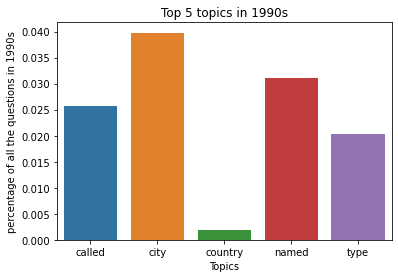

In [45]:
df_1990s = df[df['decade']==1990]
df_1990s[' Question']=df_1990s[' Question'].str.lower()

# questions that contains the word '1st'
df_1990s_1st = df_1990s[df_1990s[' Question'].str.contains("called")]


# questions that contains the word 'called'
df_1990s_called = df_1990s[df_1990s[' Question'].str.contains("city")]

# questions that contains the word 'city'
df_1990s_city = df_1990s[df_1990s[' Question'].str.contains("county")]

# questions that contains the word 'state'
df_1990s_state = df_1990s[df_1990s[' Question'].str.contains("named")]

# questions that contains the word 'said'
df_1990s_said = df_1990s[df_1990s[' Question'].str.contains('type')]

# Plot the percentages of questions from each top topics 
percent_1st_1990s=len(df_1990s_1st)/len(df_1990s)

percent_called_1990s = len(df_1990s_called)/len(df_1990s)

percent_city_1990s = len(df_1990s_city)/len(df_1990s)

percent_state_1990s = len(df_1990s_state)/len(df_1990s)

percent_said_1990s = len(df_1990s_said)/len(df_1990s)

percent_topics__list_1990s = [percent_1st_1990s, percent_called_1990s, percent_city_1990s, percent_state_1990s,
                             percent_said_1990s]

topic_list = ['called','city','country','named','type']

ax = sns.barplot(x=topic_list, y =percent_topics__list_1990s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 1990s',title='Top 5 topics in 1990s')
plt.show()


#### Decade 2000s - Top 5 topics identified: city, word, type, called

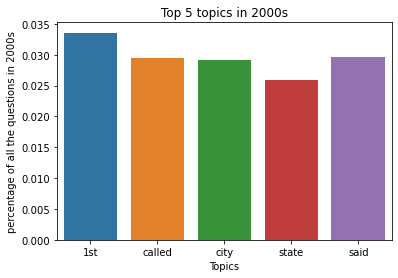

In [46]:
df_2000s = df[df['decade']==2000]
df_2000s[' Question']=df_2000s[' Question'].str.lower()

# questions that contains the word '1st'
df_2000s_1st = df_2000s[df_2000s[' Question'].str.contains("city")]


# questions that contains the word 'called'
df_2000s_called = df_2000s[df_2000s[' Question'].str.contains("seen")]

# questions that contains the word 'city'
df_2000s_city = df_2000s[df_2000s[' Question'].str.contains("like")]

# questions that contains the word 'state'
df_2000s_state = df_2000s[df_2000s[' Question'].str.contains("type")]

# questions that contains the word 'said'
df_2000s_said = df_2000s[df_2000s[' Question'].str.contains('state')]

# Plot the percentages of questions from each top topics 
percent_1st_2000s=len(df_2000s_1st)/len(df_2000s)

percent_called_2000s = len(df_2000s_called)/len(df_2000s)

percent_city_2000s = len(df_2000s_city)/len(df_2000s)

percent_state_2000s = len(df_2000s_state)/len(df_2000s)

percent_said_2000s = len(df_2000s_said)/len(df_2000s)

percent_topics__list_2000s = [percent_1st_2000s, percent_called_2000s, percent_city_2000s, percent_state_2000s,
                             percent_said_2000s]

topic_list = ['1st','called','city','state','said']

ax = sns.barplot(x=topic_list, y =percent_topics__list_2000s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 2000s',title='Top 5 topics in 2000s')
plt.show()


#### Decade 2010s - Top 4 topics identified: city,word, type, called

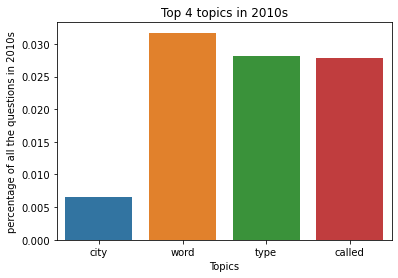

In [47]:
df_2010s = df[df['decade']==2010]
df_2010s[' Question']=df_2010s[' Question'].str.lower()

# questions that contains the word '1st'
df_2010s_1st = df_2010s[df_2010s[' Question'].str.contains("city")]


# questions that contains the word 'called'
df_2010s_called = df_2010s[df_2010s[' Question'].str.contains("word")]

# questions that contains the word 'city'
df_2010s_city = df_2010s[df_2010s[' Question'].str.contains("type")]

# questions that contains the word 'state'
df_2010s_state = df_2010s[df_2010s[' Question'].str.contains("called")]


# Plot the percentages of questions from each top topics 
percent_1st_2010s=len(df_2010s_1st)/len(df_2000s)

percent_called_2010s = len(df_2010s_called)/len(df_2010s)

percent_city_2010s = len(df_2010s_city)/len(df_2010s)

percent_state_2010s = len(df_2010s_state)/len(df_2010s)


percent_topics__list_2010s = [percent_1st_2010s, percent_called_2010s, percent_city_2010s, percent_state_2010s,]

topic_list = ['city','word','type','called']

ax = sns.barplot(x=topic_list, y = percent_topics__list_2010s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 2010s',title='Top 4 topics in 2010s')
plt.show()


**We chose to also show buzzword word clouds for each decade to visualize the Top themes in a more aesthetic way. These word cloud results match what we found from the bar graphs above.**

[('1st', 279), ('called', 227), ('named', 217), ('2', 193), ('u.s.', 192), ('used', 152), ('new', 149), ('said', 144), ('city', 125), ('1', 121)]


Text(0.5, 1.0, 'Buzzwords for questions in 1990s')

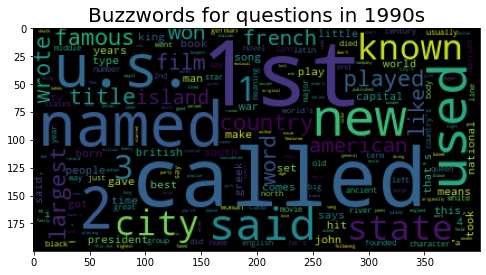

In [48]:
# Buzzwords for questions in 1980s

question_list=list(df_1980s[' Question'].values.flatten())
question_words = ','.join(question_list).split()
contents = [c for c in question_words if c not in string.punctuation]
contents =  [w.lower() for w in contents]
goodwords = [w for w in contents if w not in ENGLISH_STOP_WORDS]
goodwords = [w for w in goodwords if w!=',i' and w!='need' and w!='"the' and w!='"' and w!="it's"]  # delete this word too as it's most common and provide no insights
goodctr = Counter(goodwords)
print(goodctr.most_common(10))

wordcloud = WordCloud()
wordcloud.fit_words(goodctr)
fig = plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.title('Buzzwords for questions in 1990s', size=20)

[('named', 1481), ('called', 1426), ('2', 1265), ('u.s.', 1182), ('city', 1163), ('new', 1159), ('played', 1044), ('seen', 1032), ('film', 983), ('known', 979)]


Text(0.5, 1.0, 'Buzzwords for questions in 1990s')

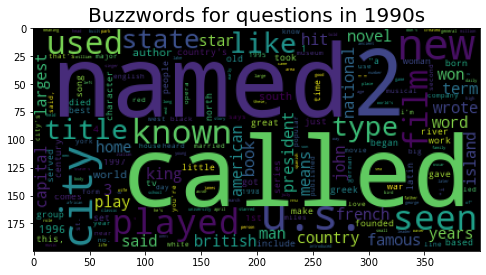

In [49]:
# Buzzwords for questions in 1990s

question_list=list(df_1990s[' Question'].values.flatten())
question_words = ','.join(question_list).split()
contents = [c for c in question_words if c not in string.punctuation]
contents =  [w.lower() for w in contents]
goodwords = [w for w in contents if w not in ENGLISH_STOP_WORDS]
goodwords = [w for w in goodwords if w!=',i' and w!='need' and w!='"the' and w!='"' and w!="it's"]  # delete this word too as it's most common and provide no insights
# goodwords = [w for w in goodwords if w!='need']
# goodwords = [w for w in goodwords if w!='the'] 
# goodwords = [w for w in goodwords if w!='"'] 
goodctr = Counter(goodwords)
print(goodctr.most_common(10))

wordcloud = WordCloud()
wordcloud.fit_words(goodctr)
fig = plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.title('Buzzwords for questions in 1990s', size=20)

[('clue', 3599), ('seen', 3275), ('crew', 3093), ('named', 2940), ('called', 2904), ('2', 2874), ('like', 2831), ('type', 2691), ('new', 2613), ('u.s.', 2465)]


Text(0.5, 1.0, 'Buzzwords for questions in 2000s')

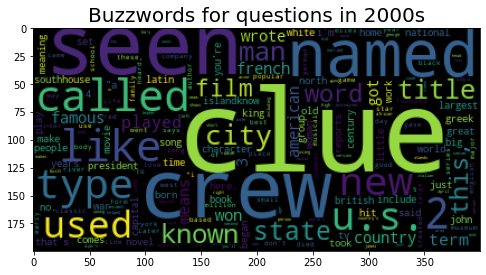

In [50]:
# Buzzwords for questions in 2000s

question_list=list(df_2000s[' Question'].values.flatten())
question_words = ','.join(question_list).split()
contents = [c for c in question_words if c not in string.punctuation]
contents =  [w.lower() for w in contents]
goodwords = [w for w in contents if w not in ENGLISH_STOP_WORDS]
goodwords = [w for w in goodwords if w!=',i' and w!='need' and w!='"the' and w!='"' and w!="it's"]  # delete this word too as it's most common and provide no insights
# goodwords = [w for w in goodwords if w!='need']
# goodwords = [w for w in goodwords if w!='the'] 
# goodwords = [w for w in goodwords if w!='"'] 
goodctr = Counter(goodwords)
print(goodctr.most_common(10))

wordcloud = WordCloud()
wordcloud.fit_words(goodctr)
fig = plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.title('Buzzwords for questions in 2000s', size=20)

[('clue', 827), ('called', 775), ('like', 711), ('named', 693), ('type', 682), ('crew', 680), ('2', 660), ('new', 619), ('word', 518), ('this,', 508)]


Text(0.5, 1.0, 'Buzzwords for questions in 2010s')

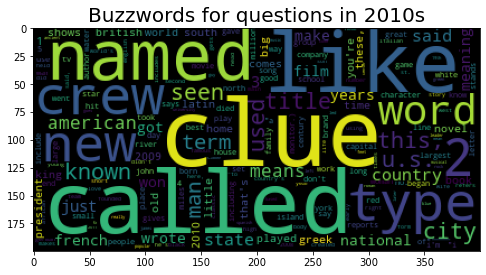

In [51]:
# Buzzwords for questions in 2010s

question_list=list(df_2010s[' Question'].values.flatten())
question_words = ','.join(question_list).split()
contents = [c for c in question_words if c not in string.punctuation]
contents =  [w.lower() for w in contents]
goodwords = [w for w in contents if w not in ENGLISH_STOP_WORDS]
goodwords = [w for w in goodwords if w!=',i' and w!='need' and w!='"the' and w!='"' and w!="it's"]  # delete this word too as it's most common and provide no insights
# goodwords = [w for w in goodwords if w!='need']
# goodwords = [w for w in goodwords if w!='the'] 
# goodwords = [w for w in goodwords if w!='"'] 
goodctr = Counter(goodwords)
print(goodctr.most_common(10))

wordcloud = WordCloud()
wordcloud.fit_words(goodctr)
fig = plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.title('Buzzwords for questions in 2010s', size=20)

###  Break Down Top 5 Topics per Decade into Rounds

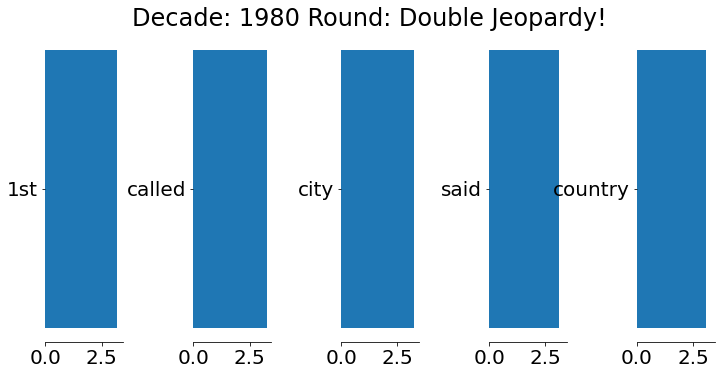

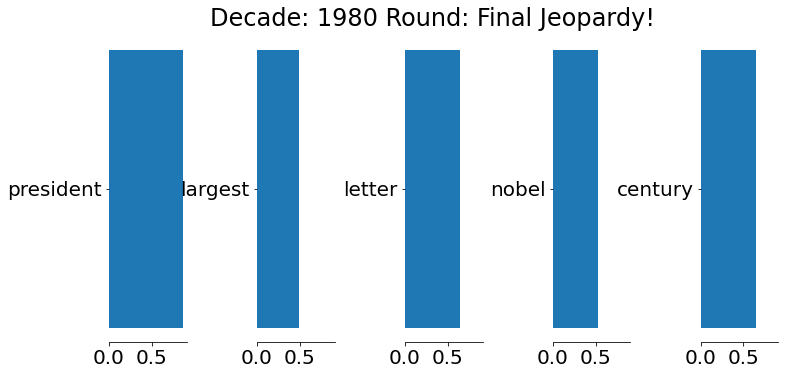

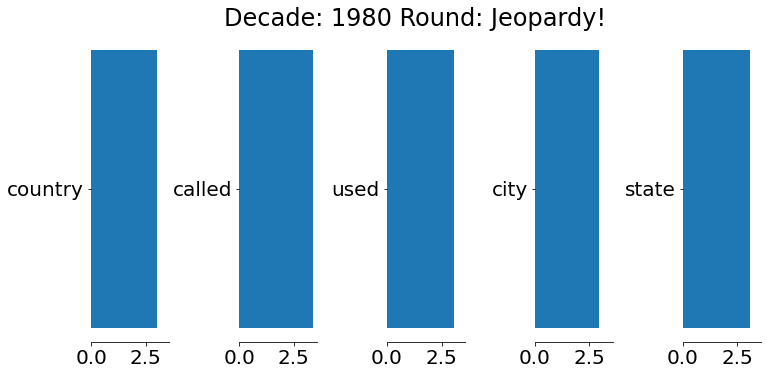

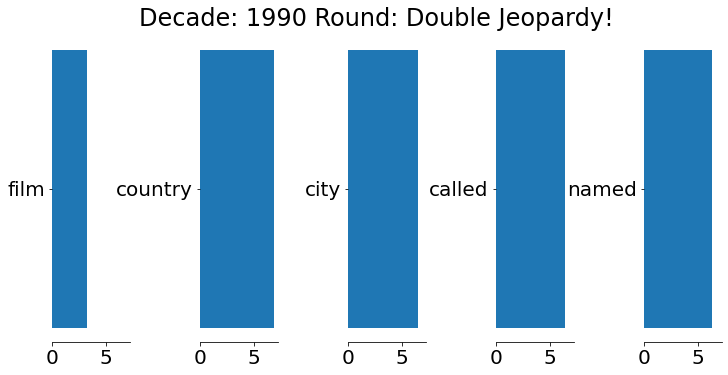

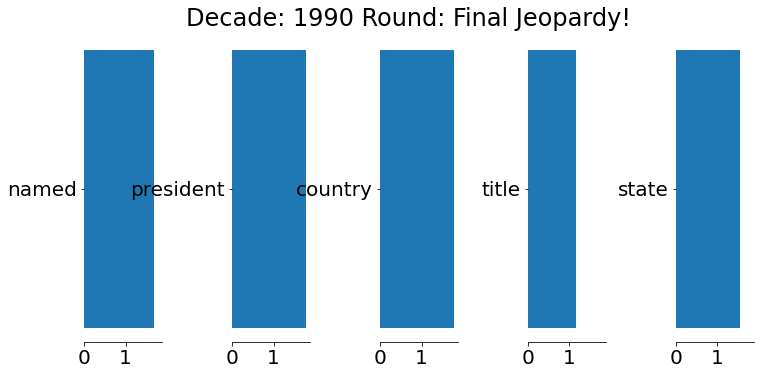

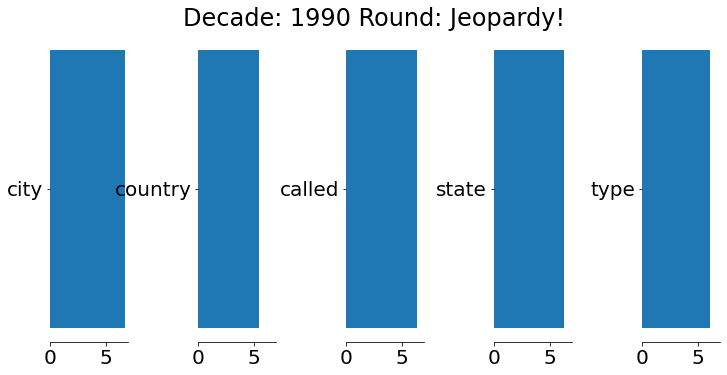

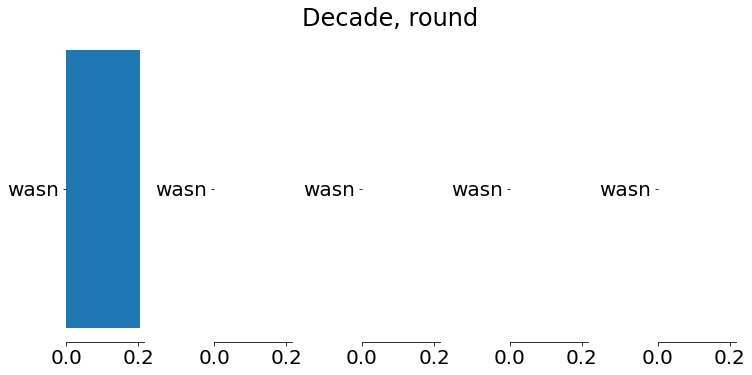

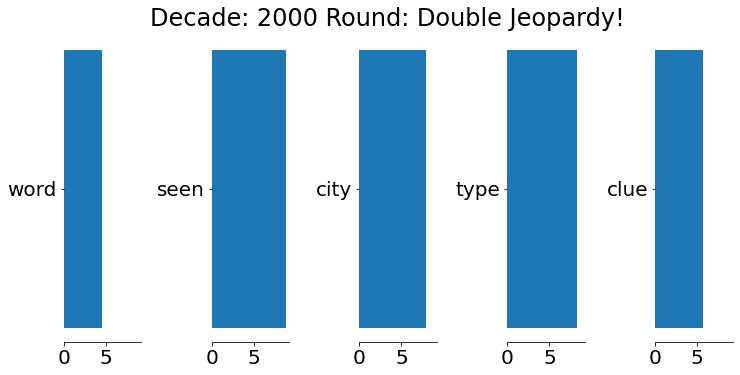

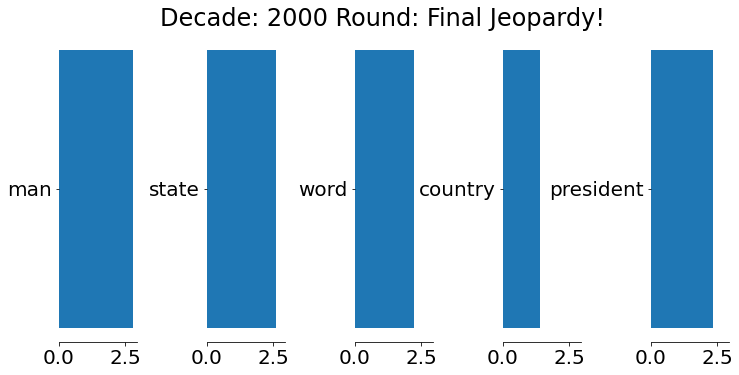

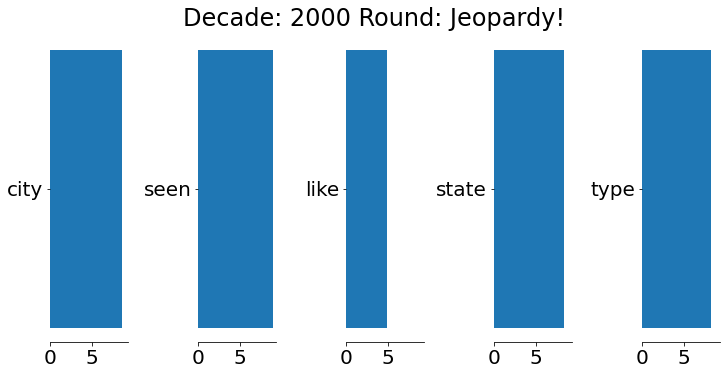

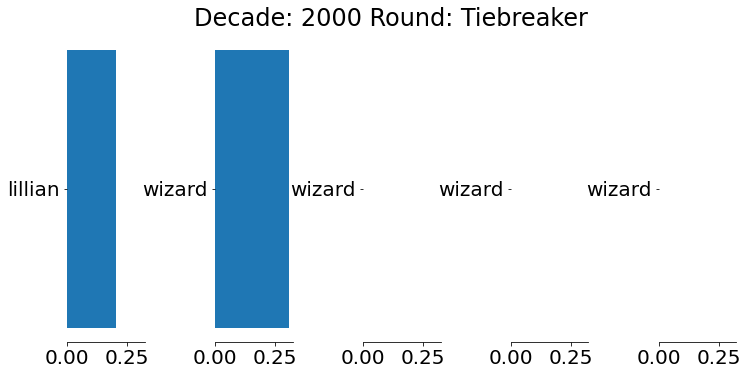

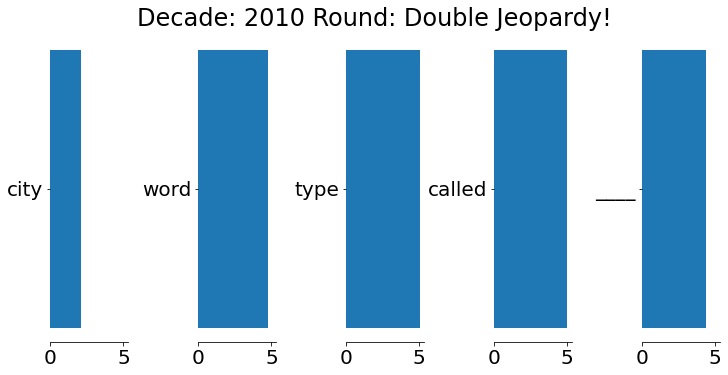

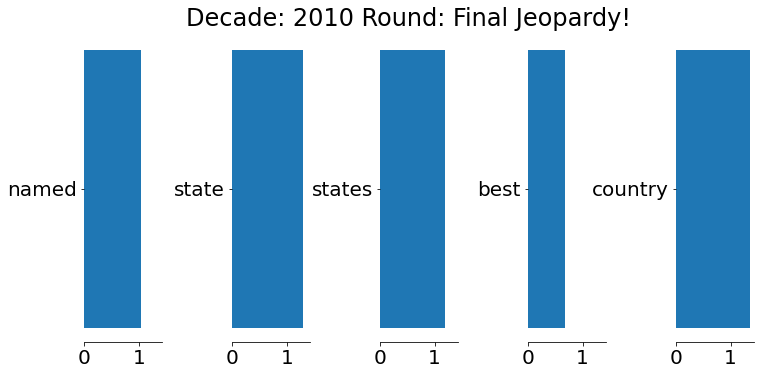

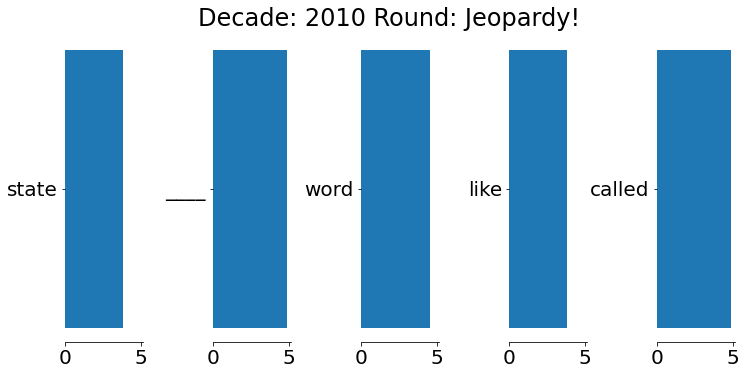

In [52]:
# Top 5 topics for different decades 
# Further break down into different rounds: Jeopardy, Double Jeopardy, Final Jeapardy
for i in range(len(topic_split_decade)):


    data_samples = list(topic_split_decade[i][" Question"])
    tfidf_vectorizer = TfidfVectorizer(
                                       max_features=n_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    try:
        plot_top_words(nmf, tfidf_feature_names, n_top_words,
                   f'Decade: {topic_split_decade[i].iloc[1,-1]} Round: {topic_split_decade[i].iloc[0,2]}')

    except: 
        plot_top_words(nmf, tfidf_feature_names, n_top_words,'Decade, round')
        


## Question 1 C

How did 'Final Jeopardy' questions change over time?

In [53]:
df_final_jeopardy = df[df[' Round']=='Final Jeopardy!']

In [54]:
df_final_jeopardy_by_decade = [pd.DataFrame(y) for x, y in df_final_jeopardy.groupby('decade', as_index=False)]

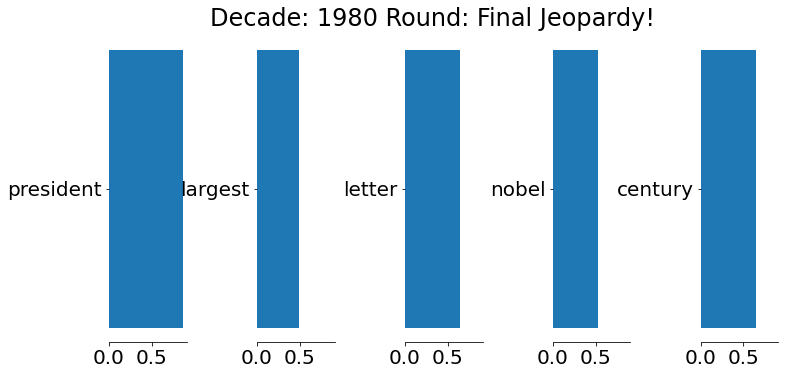

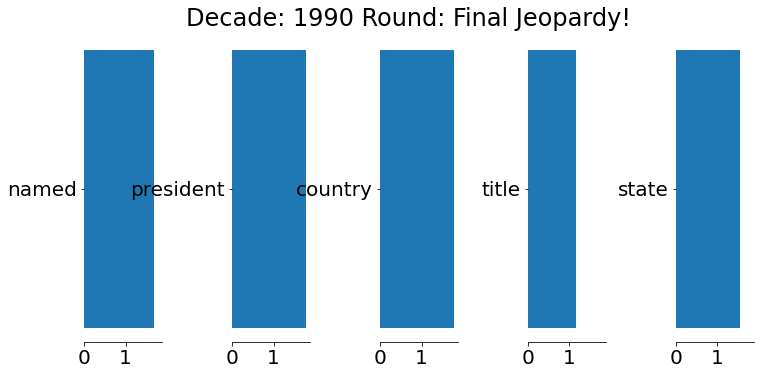

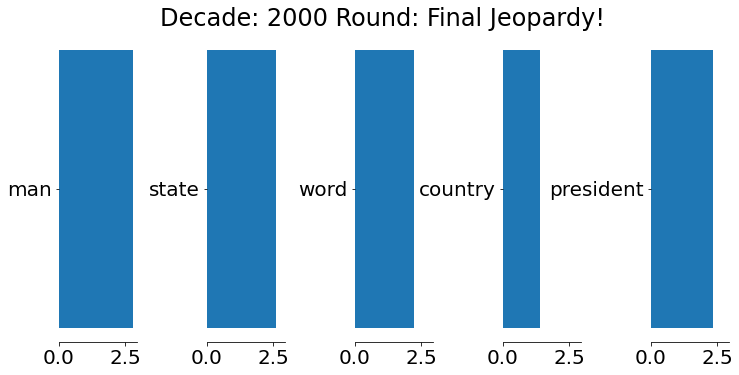

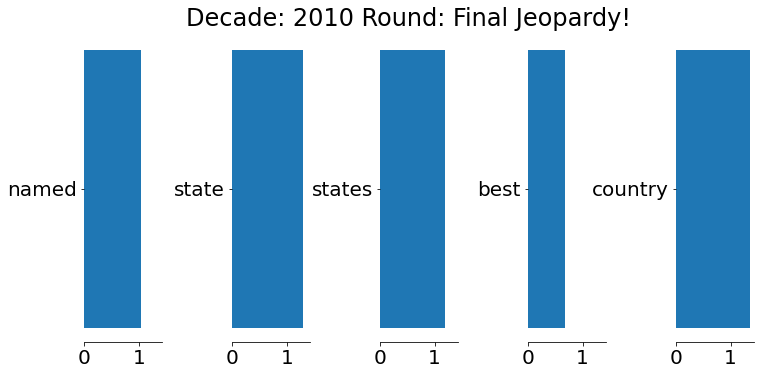

In [55]:
for i in range(len(df_final_jeopardy_by_decade)):


    data_samples = list(df_final_jeopardy_by_decade[i][" Question"])
    tfidf_vectorizer = TfidfVectorizer(
                                       max_features=n_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    try:
        plot_top_words(nmf, tfidf_feature_names, n_top_words,
                   f'Decade: {df_final_jeopardy_by_decade[i].iloc[1,-1]} Round: {df_final_jeopardy_by_decade[i].iloc[0,2]}')

    except: 
        plot_top_words(nmf, tfidf_feature_names, n_top_words,'Decade, round')
        

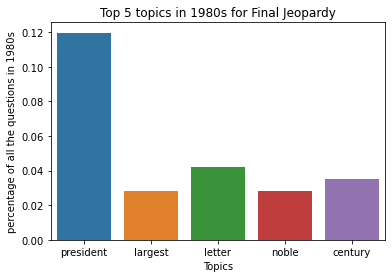

In [56]:
# 1980s - final jeopardy

df_1980s = df_final_jeopardy[df_final_jeopardy['decade']==1980]
df_1980s[' Question']=df_1980s[' Question'].str.lower()

# questions that contains the word '1st'
df_1980s_president = df_1980s[df_1980s[' Question'].str.contains("president")]


# questions that contains the word 'called'
df_1980s_largest = df_1980s[df_1980s[' Question'].str.contains("largest")]

# questions that contains the word 'city'
df_1980s_letter = df_1980s[df_1980s[' Question'].str.contains("letter")]

# questions that contains the word 'state'
df_1980s_nobel = df_1980s[df_1980s[' Question'].str.contains("nobel")]

# questions that contains the word 'state'
df_1980s_century = df_1980s[df_1980s[' Question'].str.contains("century")]



# Plot the percentages of questions from each top topics 
percent_president_1980s=len(df_1980s_president)/len(df_1980s)

percent_largest_1980s = len(df_1980s_largest)/len(df_1980s)

percent_letter_1980s = len(df_1980s_letter)/len(df_1980s)

percent_nobel_1980s = len(df_1980s_nobel)/len(df_1980s)

percent_century_1980s = len(df_1980s_century)/len(df_1980s)


percent_topics__list_1980s = [percent_president_1980s, percent_largest_1980s, percent_letter_1980s,
                              percent_nobel_1980s,percent_century_1980s]

topic_list = ['president','largest','letter','noble','century']

ax = sns.barplot(x=topic_list, y = percent_topics__list_1980s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 1980s',title='Top 5 topics in 1980s for Final Jeopardy')
plt.show()

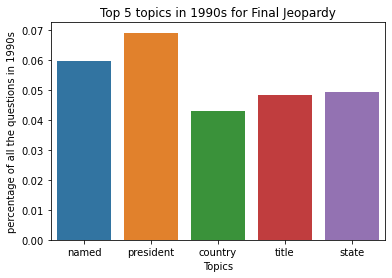

In [57]:
# 1990s - final jeopardy

df_1990s = df_final_jeopardy[df_final_jeopardy['decade']==1990]
df_1990s[' Question']=df_1990s[' Question'].str.lower()

# questions that contains the word '1st'
df_1990s_president = df_1990s[df_1990s[' Question'].str.contains("named")]


# questions that contains the word 'called'
df_1990s_largest = df_1990s[df_1990s[' Question'].str.contains("president")]

# questions that contains the word 'city'
df_1990s_letter = df_1990s[df_1990s[' Question'].str.contains("country")]

# questions that contains the word 'state'
df_1990s_nobel = df_1990s[df_1990s[' Question'].str.contains("title")]

# questions that contains the word 'state'
df_1990s_century = df_1990s[df_1990s[' Question'].str.contains("state")]



# Plot the percentages of questions from each top topics 
percent_president_1990s=len(df_1990s_president)/len(df_1990s)

percent_largest_1990s = len(df_1990s_largest)/len(df_1990s)

percent_letter_1990s = len(df_1990s_letter)/len(df_1990s)

percent_nobel_1990s = len(df_1990s_nobel)/len(df_1990s)

percent_century_1990s = len(df_1990s_century)/len(df_1990s)


percent_topics__list_1990s = [percent_president_1990s, percent_largest_1990s, percent_letter_1990s,
                              percent_nobel_1990s,percent_century_1990s]

topic_list = ['named','president','country','title','state']

ax = sns.barplot(x=topic_list, y = percent_topics__list_1990s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 1990s',title='Top 5 topics in 1990s for Final Jeopardy')
plt.show()

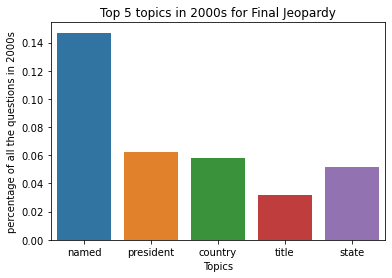

In [58]:
# 2000s - final jeopardy

df_2000s = df_final_jeopardy[df_final_jeopardy['decade']==2000]
df_2000s[' Question']=df_2000s[' Question'].str.lower()

# questions that contains the word '1st'
df_2000s_president = df_2000s[df_2000s[' Question'].str.contains("man")]


# questions that contains the word 'called'
df_2000s_largest = df_2000s[df_2000s[' Question'].str.contains("state")]

# questions that contains the word 'city'
df_2000s_letter = df_2000s[df_2000s[' Question'].str.contains("word")]

# questions that contains the word 'state'
df_2000s_nobel = df_2000s[df_2000s[' Question'].str.contains("country")]

# questions that contains the word 'state'
df_2000s_century = df_2000s[df_2000s[' Question'].str.contains("president")]



# Plot the percentages of questions from each top topics 
percent_president_2000s=len(df_2000s_president)/len(df_2000s)

percent_largest_2000s = len(df_2000s_largest)/len(df_2000s)

percent_letter_2000s = len(df_2000s_letter)/len(df_2000s)

percent_nobel_2000s = len(df_2000s_nobel)/len(df_2000s)

percent_century_2000s = len(df_2000s_century)/len(df_2000s)


percent_topics__list_2000s = [percent_president_2000s, percent_largest_2000s, percent_letter_2000s,
                              percent_nobel_2000s,percent_century_2000s]

topic_list = ['named','president','country','title','state']

ax = sns.barplot(x=topic_list, y = percent_topics__list_2000s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 2000s',title='Top 5 topics in 2000s for Final Jeopardy')
plt.show()

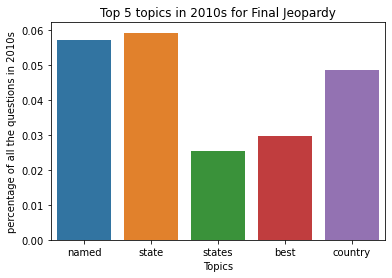

In [59]:
# 2010s - final jeopardy

df_2010s = df_final_jeopardy[df_final_jeopardy['decade']==2010]
df_2010s[' Question']=df_2010s[' Question'].str.lower()

# questions that contains the word '1st'
df_2010s_president = df_2010s[df_2010s[' Question'].str.contains("named")]


# questions that contains the word 'called'
df_2010s_largest = df_2010s[df_2010s[' Question'].str.contains("state")]

# questions that contains the word 'city'
df_2010s_letter = df_2010s[df_2010s[' Question'].str.contains("states")]

# questions that contains the word 'state'
df_2010s_nobel = df_2010s[df_2010s[' Question'].str.contains("best")]

# questions that contains the word 'state'
df_2010s_century = df_2010s[df_2010s[' Question'].str.contains("country")]



# Plot the percentages of questions from each top topics 
percent_president_2010s=len(df_2010s_president)/len(df_2010s)

percent_largest_2010s = len(df_2010s_largest)/len(df_2010s)

percent_letter_2010s = len(df_2010s_letter)/len(df_2010s)

percent_nobel_2010s = len(df_2010s_nobel)/len(df_2010s)

percent_century_2010s = len(df_2010s_century)/len(df_2010s)


percent_topics_list_2010s = [percent_president_2010s, percent_largest_2010s, percent_letter_2010s,
                              percent_nobel_2010s,percent_century_2010s]

topic_list = ['named','state','states','best','country']

ax = sns.barplot(x=topic_list, y = percent_topics_list_2010s)
ax.set(xlabel='Topics',ylabel='percentage of all the questions in 2010s',title='Top 5 topics in 2010s for Final Jeopardy')
plt.show()

**Throughout the decades, "named" and "president" have remained common topics for Final Jeopardy questions. In terms of difficulty level increasing, it's hard to tell from these graphs since the themes have mostly remained constant. We can tell, however, that if you want to win Final Jeopardy, you'd find more success in studying Geograph and President related questions, as well as famous names. In the 1980's the ratio of Final Jeopardy questions being about "Presidents" was much higher than in later decades.**

**We considered monetary value in terms of dificulty increase/decrease in questions, but a 200 dollar question today could be much harder than a 200 dollar question back then. We do think the probability that Final Jeopardy questions in 1980 would be more obscure and more likely a random factoid is much higher than in the 2010's. Nowadays, Final Jeopardy questions are more likely to be something that the general public does know. One reason for this could be that with technology, it's incredibly easy to gather large swaths of information quickly. In the 1980's it would have taken a much longer time to take in a similar amount. Therefore, it was ok that the questions were easier because the average trivia contestant didn't have as many random facts and figures in their brain.**

# Question 2a

## Data Cleaning
 - Removed punctuation in values
 - Excluded values associated with Daily Doubles
     - Contestants can place arbitrary values on the question
     - Observations excluded because the original value of the question not captured in the dataset
 - Converted column to integer type
 - Excluded values >$2000

In [213]:
# 146 unique values in Value column
df[' Value'] = df[' Value'].str.replace(',','')
df[' Value'] = df[' Value'].str.replace('$','')
len(df[' Value'].unique())

146

In [154]:
# Some weird question values which are likely associated with Daily Doubles
# ie a question worth $13,800... wow!
df[' Value'].unique()[-10:]

array(['8500', '585', '1534', '13800', '5001', '4238', '16400', '1347',
       '2547', '11200'], dtype=object)

In [18]:
# Remove nones so can convert to int
df2 = df[df[" Value"] != "None"].copy()

In [19]:
# Remove daily double with weird values
df_clean = df2[df2[' Value'].str.endswith('00')]
df_clean[' Value']=df_clean[' Value'].astype(int)

In [158]:
# Select only values less than or equal to $2000
df_clean = df_clean[df_clean[' Value']<=2000]
np.sort(df_clean[' Value'].unique())

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])

In [242]:
def plot_top_words(df, model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, n_components, figsize=(7, 3), sharex=True)
    axes = axes.flatten()
    
    result = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        result.extend(top_features[0:2])
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 14})
        
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18, x=.1,y=1.1)
        try:
            t = random.choice(list(df[df[" Question"].str.contains(' '+top_features[0]+' ', case=False)][" Question"]))
            print(f"sample of topic {topic_idx+1}: {t}")
        except:
            print(top_features[0])
            print('NA')

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    return result

In [145]:
# 20 unique values after data cleaning
len(sorted(df_clean[' Value'].unique()))

20

sample of topic 1: English is also widely spoken in this largest French-speaking city outside of Paris
sample of topic 2: This country is thought to have invented gunpowder, as well as soy sauce
sample of topic 3: You can fill some large shoes if you're this yeti relative that's also called a sasquatch


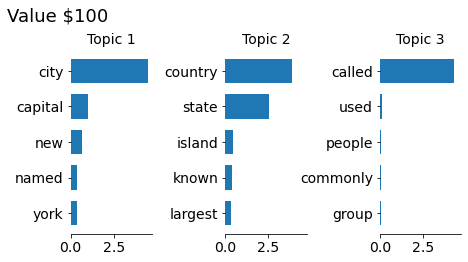


sample of topic 1: In 1491 this country outlawed golf, soccer & other sports that were taking young men away from military training
sample of topic 2: After 3 previous acquittals, this reputed crime family boss was finally convicted in New York City on April 2, 1992
sample of topic 3: The "Wizard" of Oz is from Omaha, Nebraska, not far from this state where Dorothy lives


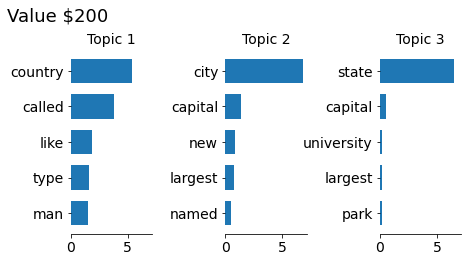


sample of topic 1: He played for the Kansas City Monarchs before he joined the Brooklyn Dodgers in 1947
sample of topic 2: Title domicile of the bear seen here:
sample of topic 3: This "candle", a type of firework, splits up its charge to produce separate groups of sparks


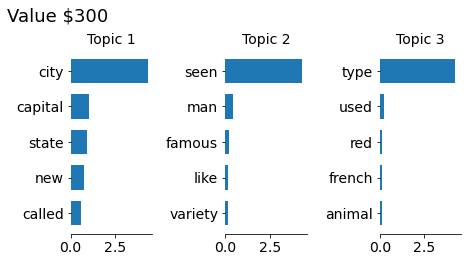

In [238]:
n_components = 3
num_words = 5
for val in sorted(df_clean[' Value'].unique())[:3]:
    df_sel = df_clean[df_clean[' Value']==val]
    data_samples = list(df_sel[' Question'])
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    plot_top_words(df_sel, nmf, tfidf_feature_names, num_words,
               f'Value ${val}')
    print()

## Initial Observations

### Common question asking words

Initial runs of the NMF model show that there are a couple common words to Jeopardy that are not included in scikit-learn's stop words. These words are related to the structure of asking questions rather than the content of the question (i.e. "called", "seen", "used"). Since these words are not useful to our topic analysis, we added the noticeable words to the stop words list and reduced the max document frequency to 0.85.

In [164]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(["called",'used','named','known','like','seen','clue','type'])

### Remove daily doubles with arbitrary values
Another anamoly of the data showed up in the values with low observation counts, such as $1100 with only 63 observations. These questions seemed to be associated with daily doubles. We decided exclude values with fewer than 200 observations to again exclude daily doubles which would have arbitrary values.

In [268]:
df_clean[' Value'].value_counts()

400     42244
800     31860
200     30455
1000    21640
600     20377
2000    12829
1200    11772
1600    11040
100      9029
500      9016
300      8663
1500      546
1400      228
700       203
1800      182
900       114
1300       75
1100       63
1700       44
1900       28
Name:  Value, dtype: int64

sample of topic 1: (VIDEO DAILY DOUBLE): "(Hi, I'm Janet Leigh)  In "Psycho", it's the name of the establishment where I met my end"
sample of topic 2: Milton Friedman, or a London magazine founded in 1843 that might discuss his views
sample of topic 3: Rubricate means to write or paint in this color


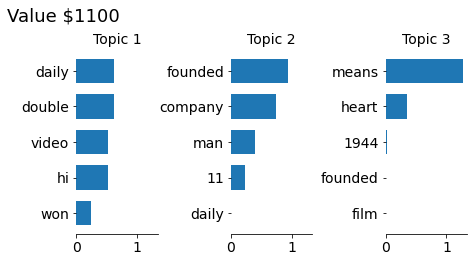

['daily', 'founded', 'means']

In [239]:
# Value $1100
val=1100
df_sel = df_clean[df_clean[' Value']==val]
data_samples = list(df_sel[' Question'])
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2,
                               max_features=n_features,
                               stop_words=my_stop_words)

tfidf = tfidf_vectorizer.fit_transform(data_samples)
nmf = NMF(n_components=n_components, random_state=1,
      alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(df_sel, nmf, tfidf_feature_names, num_words,
           f'Value ${val}')

In [209]:
# Sample of $1100 questions which were all daily doubles
df_sel = df_clean[df_clean[' Value']==1100]
df_sel[df_sel[' Question'].str.contains('Daily',case=False)][[' Value', ' Question','year']]

,Value,Question,year
122196,1100,"(VIDEO DAILY DOUBLE): ""(Hi, I'm Janet Leigh) ...",1999
153820,1100,(VIDEO Daily Double): (Here is a participant i...,1998
167304,1100,"(AUDIO DAILY DOUBLE): Heard here, it was Briti...",1990
168279,1100,"(VIDEO DAILY DOUBLE): ""(Hi, I'm Jeri Ryan) In...",1998


## Common topics by value grouping

### Low Values
  - geography (city, capital, state)
  - "largest"
  - wars and kings
### Medium Values
  - same geography topics as low category
  - other country topics like African, European, French
### High Values
  - Latin
  - film and novel

sample of topic 1: This city is so big, it covers parts of 3 of Egypt's adminstrative governorates
sample of topic 2: Teri, still on the run with Emily's baby, crossed the border into this country which elected Vincente Fox in 2000
sample of topic 3: By population, it's the largest city of the state seen here (California)


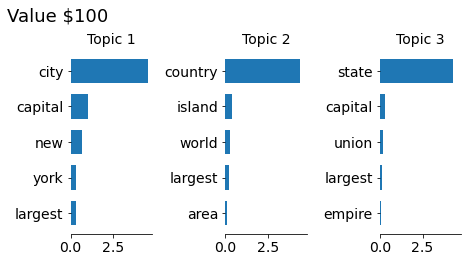


sample of topic 1: Zechariah predicted the Messiah would enter this city upon an ass
sample of topic 2: Its state beverage: orange juice
sample of topic 3: Girls can see geysers in this country where the name originated


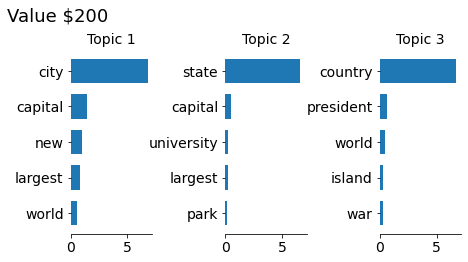


sample of topic 1: He played for the Kansas City Monarchs before he joined the Brooklyn Dodgers in 1947
sample of topic 2: This country denounced the awarding of the 1989 Nobel Peace Prize to the Dalai Lama as politically motivated
sample of topic 3: This Sunshine State once had east & west portions; the western part now belongs to Ala., Miss. & La.


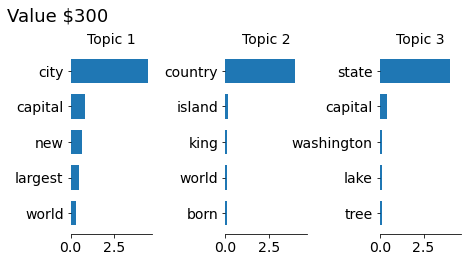


sample of topic 1: The nearly 40 insurance firms based in this Connecticut city make it the "Insurance Capital of the World"
sample of topic 2: Philippe Nguyen Kim Dien, an activist archbishop of Hue, died under house arrest in this country in 1988
sample of topic 3: The NBA in a state that meets at Four Corners: Dixieland, bebop or swing


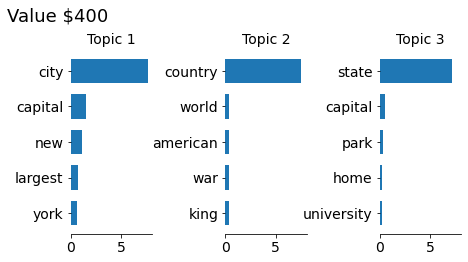


sample of topic 1: This Missouri city is headquarters to the Reorganized Church of Jesus Christ of Latter Day Saints
sample of topic 2: The first First Lady who was a college graduate, she banned all alcoholic beverages from state functions
sample of topic 3: It's the word missing from the Oliver Sacks title “The Man Who ___ His Wife For A Hat”


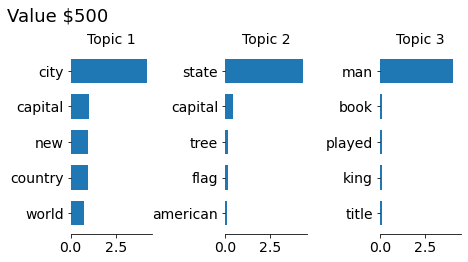


sample of topic 1: In the 1940s he & Lincoln Kirstein founded the New York City Ballet
sample of topic 2: Minute Man National Historical Park is located between these 2 Massachusetts cities made famous in April 1775
sample of topic 3: This N. European country was a grand duchy ruled by Russia before gaining its independence in 1917


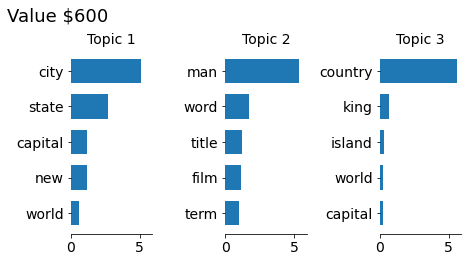


sample of topic 1: William Penn's plan for the city covered a strip of land between the Schuylkill & this river
sample of topic 2: In 1968 Hugo Montenegro took this title tune to No. 2 on the pop charts:
sample of topic 3: In 1963 Ahmed Ben Bella became the first president of this north African country


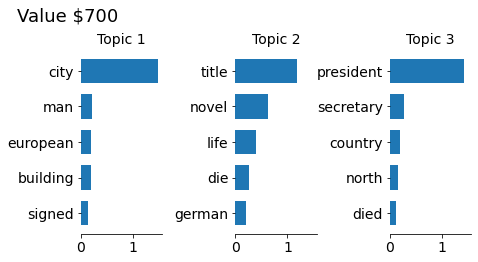


sample of topic 1: The capital city of Hell, according to Milton; it was a riot!
sample of topic 2: "Barbaric" often precedes this word derived from Middle English meaning "harsh cry"
sample of topic 3: In 1998 Ty Herndon had a country hit about "A Man Holdin' On To A Woman" doing this


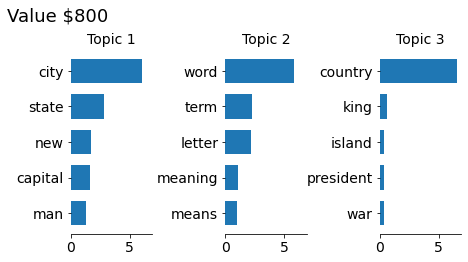


sample of topic 1: Dijon, France is the largest city of this colorful region that's famous for its wines
sample of topic 2: This European country is in last place in the "L"s
sample of topic 3: L.A.'s Starline Tours can take you past Hollywood landmarks in this, another word for a streetcar


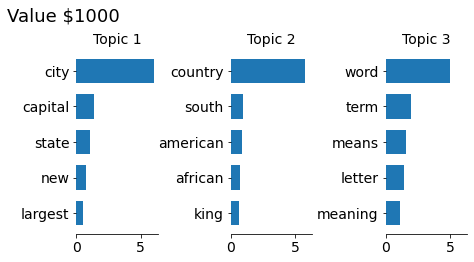


sample of topic 1: This Yucatan city whose ruins are a UNESCO world heritage site gave way to Mayapan as a Mayan political center
sample of topic 2: This word for the art & science of good eating goes back to Greek for "belly"
sample of topic 3: This country star became a sitcom grandma at the end of her first season on the WB


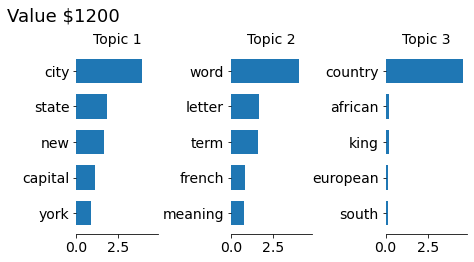


sample of topic 1: Ruins in Tunisia today are from the later Roman occupation of this city founded by the Phoenicians around 814 B.C.
sample of topic 2: The title locale of this Robert Louis Stevenson novel is 9 miles long & 5 miles wide
sample of topic 3: A castle in this world capital was once the home of the kings of Bohemia


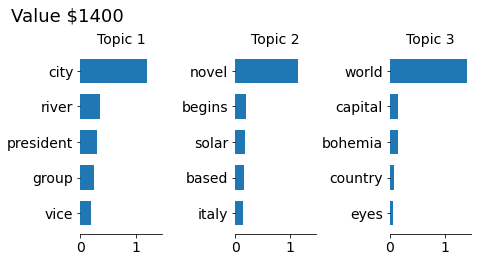


sample of topic 1: A basilica in this northeastern Italian city contains the tomb of Saint Anthony
sample of topic 2: This type of romantic composition for piano derives its name from the Latin word for "night"
sample of topic 3: The first president who wasn't born a British subject was this New Yorker


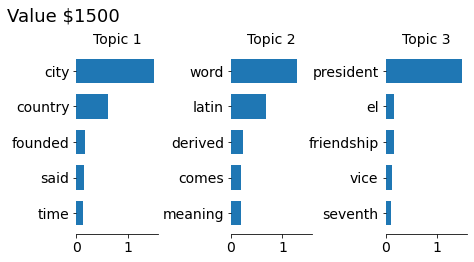


sample of topic 1: Za is a slang word for this treat
sample of topic 2: Herdin' some sheep with Abraham in this Sumerian city with a 2-letter name
sample of topic 3: "'Forward the light brigade!' Was there a man dismay'd?  Not tho' the soldier knew some one had blunder'd"


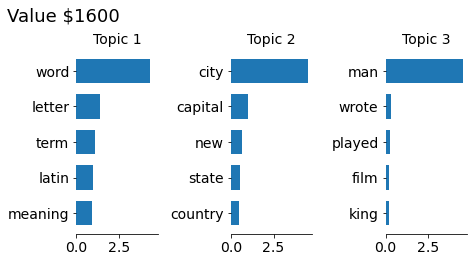


sample of topic 1: It's the large northeastern city where George was first inaugurated, as Washington, D.C. hadn't been built yet
sample of topic 2: Site of a decisive Sept. 1863 battle, this Georgia river takes its name from an Indian word meaning "river of death"
sample of topic 3: This Iowa city was named for a French Canadian, the first white man to settle permanently in what is now Iowa


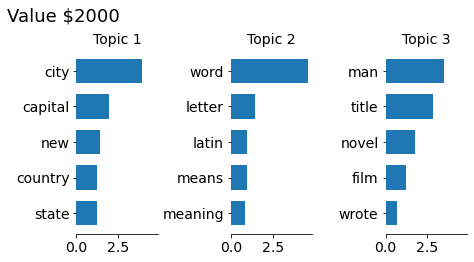

In [266]:
result = {}
for val in sorted(df_clean[' Value'].unique()):
    df_sel = df_clean[df_clean[' Value']==val]
    # Analyze value if >200 observations
    if len(df_sel)>200:
        data_samples = list(df_sel[' Question'])
        tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2,
                                       max_features=n_features,
                                       stop_words=my_stop_words)

        tfidf = tfidf_vectorizer.fit_transform(data_samples)
        nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        t = plot_top_words(df_sel, nmf, tfidf_feature_names, num_words,
                   f'Value ${val}')
        result[val] = t
        print()

### Top words

Looking at the top words over the first 3 topics by value, we see that geography is critical at every value amount. In the more valuable categories, contestants seem to be often asked to identify a word. The other noticeable word below is "man." While Jeopardy is unlikely trying to be sexist, the frequency of "man" and other masculine words like "king" reflect the sexism in our history books.

In [248]:
# Top word in topic
r1 = {k:[v[0],v[2],v[4]] for k,v in result.items()}
pd.DataFrame.from_dict(r1,orient='index', columns=['Topic 1','Topic 2','Topic 3'])

,Topic 1,Topic 2,Topic 3
100,city,country,state
200,city,state,country
300,city,country,state
400,city,country,state
500,city,state,man
600,city,man,country
700,city,title,president
800,city,word,country
1000,city,country,word
1200,city,word,country


### Second top word

Similar to above, locations are common question topics (capital and island). In the high value categories, contestants are asked more word game questions that involve a "letter." An example of this is "Subtract a letter from this South American ruminant & you get a Buddhist monk."

In [249]:
# Second top word in topic
r2 = {k:[v[1],v[3],v[5]] for k,v in result.items()}
pd.DataFrame.from_dict(r2,orient='index', columns=['Topic 1','Topic 2','Topic 3'])

,Topic 1,Topic 2,Topic 3
100,capital,island,capital
200,capital,capital,president
300,capital,island,capital
400,capital,world,capital
500,capital,capital,book
600,state,word,king
700,man,novel,secretary
800,state,term,king
1000,capital,south,term
1200,state,letter,african


### Conclusion

Geography is by far the most common topic; thus being able to identify cities, states, capitals, countries, islands, rivers seems critical to playing Jeopardy. Latin as a common term in the more valuable questions is surprising yet not surprising. Although Latin is not used today, it is important as it forms a basis for many human languages. It is also a snotty topic that educated people like to advertise knowing. Finally, another surprising yet sadly unsurprising finding was the commonality of the word "man" and other masculine words like "king." It is common knowledge that history books reflect the stories of the "winners" which has in the past been white men. This dataset only contains up to 2012 but it would be interesting to see if Jeopardy has become more "woke" and asks questions about male and female history more equally. Hopefully, as history books are extended to include more diversity, so too will Jeopardy's questions.

# Question 2b

## Too many values (leading to explosive combinatortics - so we reduced to 4 kinds)
- this also leads to a dataframe with only jeopardy and double jeopardy question

In [249]:
df = df[df[" Value"] != "None"].copy()
df[" Value"] = df[" Value"].str.replace(',', '')
df[" Value"] = df[" Value"].str.replace('$', '')
df[" Value"] = df[" Value"].astype(int)
df['Value_grp'] = np.nan
df['Value_grp'].loc[df[' Value']<=500] = 'Value <= 500'
df['Value_grp'].loc[(df[' Value']>500) & (df[' Value']<=1000)] = 'Value <= 1000'
df['Value_grp'].loc[(df[' Value']>1000) & (df[' Value']<=1500)] = 'Value <= 1500'
df['Value_grp'].loc[(df[' Value']>1500) & (df[' Value']<=2000)] = 'Value <= 2000'

/Users/victor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [334]:
def plot_top_words(data_frame, model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, x=.5, y=1.2, fontsize=24)
        
        for q in list(data_frame[data_frame[" Question"].str.contains(top_features[0])][" Question"])[:1]:
            print(f"sample of each topic: {q}")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

In [335]:
def round_year_plot(df, decade, grp):
    n_features = 1000
    n_components = 3
    n_top_words = 1
    
    data_frame = df[(df.decade == decade)&
                           (df.Value_grp == grp)]
    
    data_samples = list(data_frame[" Question"])

    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')

    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5, max_iter=400).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    plot_top_words(data_frame, nmf, tfidf_feature_names, n_top_words,
                   f'NMF: {grp} Decade: {decade}')

sample of each topic: In the 1984 Olympics, Alexi Grewal won a gold medal in cycling for this country
sample of each topic: It was originally called bib-label lithiated lemon-lime soda
sample of each topic: Founder of the nursing profession, she was named after the city in which she was born


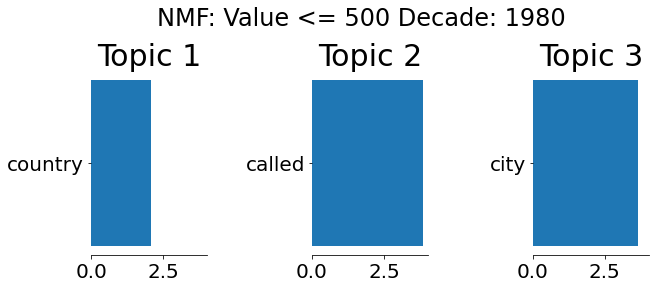

sample of each topic: Dog lovers look forward to the Westminster Kennel Club dog show, held each February in this city
sample of each topic: People Magazine called his 1997 solo album "Destination Anywhere", "Tres Bon"
sample of each topic: Under the 1814 Treaty of Kiel, this country gave Norway to Sweden but kept Greenland & other islands


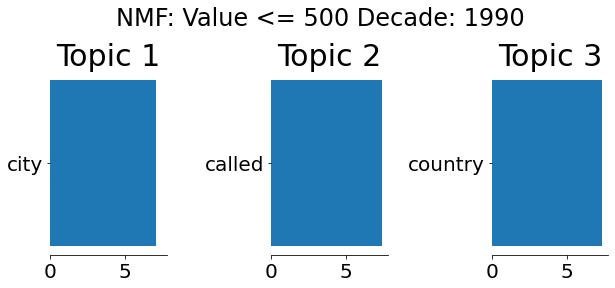

sample of each topic: The city of Yuma in this state has a record average of 4,055 hours of sunshine each year
sample of each topic: Nudge, nudge, wink, wink!  This man seen here starred on a classic British comedy show
sample of each topic: On the pH scale, a pH of 7 indicates this type of solution


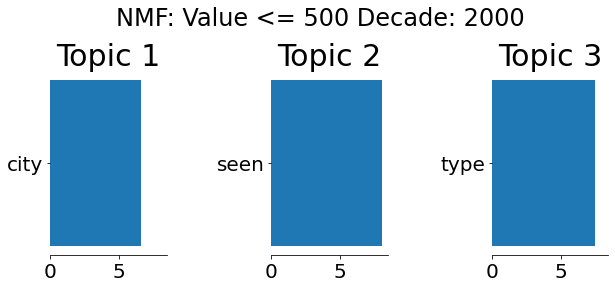

sample of each topic: If this part of a peach is downy or fuzzy, the fruit's called a peach; if it's smooth, a nectarine
sample of each topic: David Yazbek & Jeffrey Lane's musical "____ ____ Scoundrels"
sample of each topic: This largest Alaskan city lies at the head of cook inlet on the Kenai peninsula


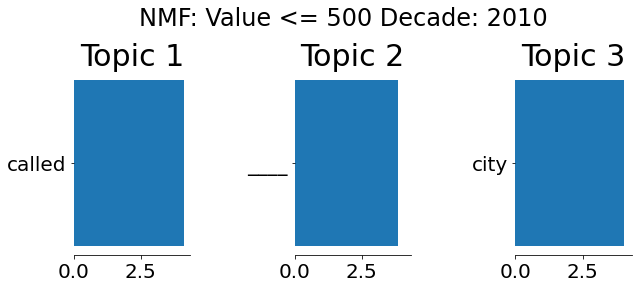

sample of each topic: In 1962, this country became a constitutional monarchy under King Hassan II
sample of each topic: O. Henry called it the most  “purely American” holiday
sample of each topic: Though it has the same name, Benetton's perfume wasn't named for this controversial Sean Penn film


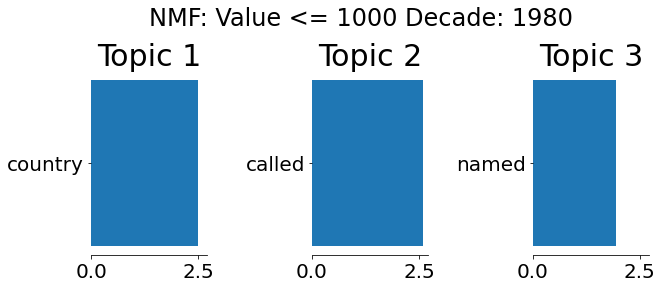

sample of each topic: The United Steelworkers of America is headquartered in this city
sample of each topic: Silent screen swashbuckler; his film "The Black Pirate" has been called "a definitive pirate movie"
sample of each topic: In February 1904 this country attacked the Russian fleet at Port Arthur


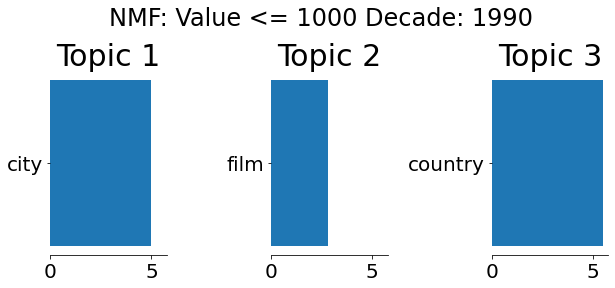

sample of each topic: This second-largest Alaskan city wasn't named for an actor
sample of each topic: The shorter glass seen here, or a quaint cocktail made with sugar & bitters
sample of each topic: The largest tree, the General Sherman in California, is this type, also called a Sierra Redwood


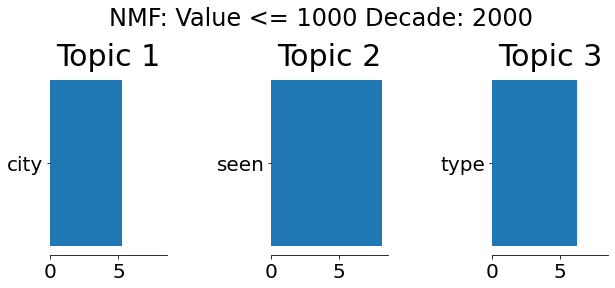

sample of each topic: It's a type of bounce house, or a dance made famous by Michael Jackson
sample of each topic: 2010 brought Travolta as a spy in "From ____ with Love"
sample of each topic: 5-letter word for the hard interior of a peach


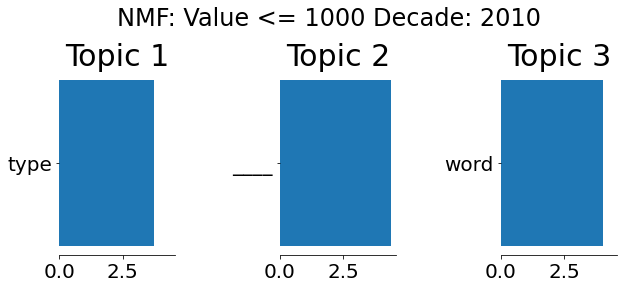

sample of each topic: (AUDIO DAILY DOUBLE): This TV western star reached the top of the charts in 1964 with the following song: "He lay face down in the desert sand, clutching a six-gun in his hand, shot from behind..."
sample of each topic: Chorea, as in choreographer, is a condition associated with rheumatic fever formerly called this
sample of each topic: Not until 1939 did West Virginia pay off its 68-year-old financial debt to this state


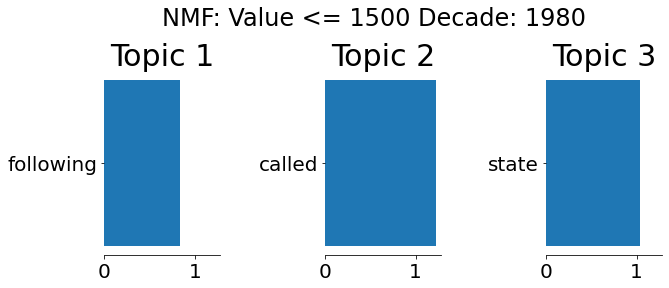

sample of each topic: (VIDEO DAILY DOUBLE): Action seen here: (Curly Howard) - "Hey you, this is no time to play games - ewww!"
sample of each topic: The natural features that gave this Montana city its name now provide hydroelectric power


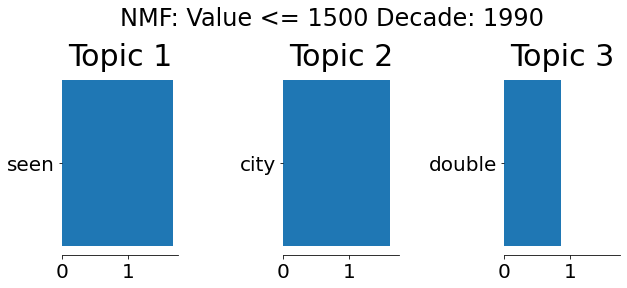

sample of each topic: (James Lipton reads the clue.) You finished "The Sick Child" in 1886.  7 years later, the world would recoil from "The Scream."  Tell us about your pain
sample of each topic: Future leader of the UK seen here on the right in the 1880s
sample of each topic: In this type of race you have to zigzag between flags or other obstacles in proper order


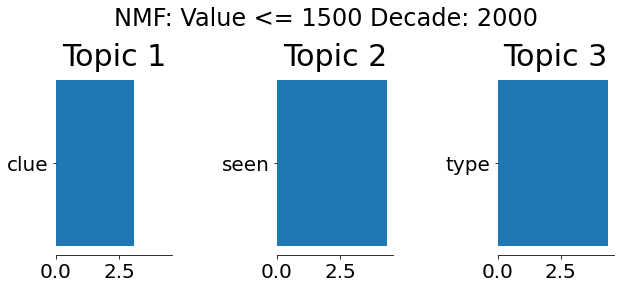

sample of each topic: Maize is another word for this
sample of each topic: This dog breed seen here is a loyal and protective companion
sample of each topic: Sultan Ibrahim is a Mideastern name for red mullet, a type of this creature


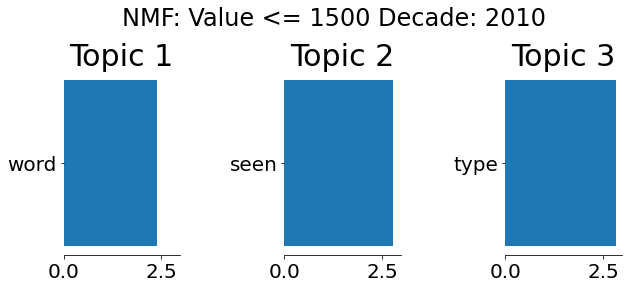

sample of each topic: Condition of the skunk in the title of the following 1973 Top 20 hit:  "Take a whiff on me, that ain't no rose! / Roll up yer window and hold yer nose"
sample of each topic: 1 of 3 Major League Baseball teams with state rather than city names


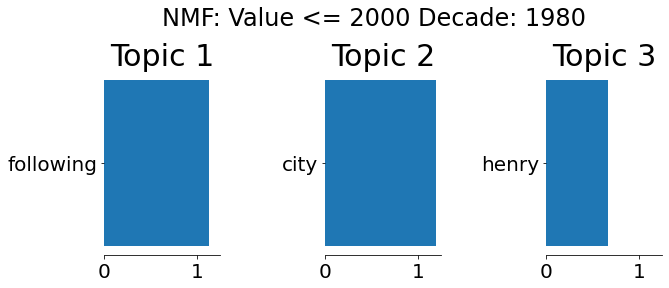

sample of each topic: 17th century Flemish master known for painting women like the one seen here:
sample of each topic: By a vote of its parliament, the Althing, this island country adopts Christianity
sample of each topic: Milton Friedman said, "There's only one place where inflation is made: that's in" this city


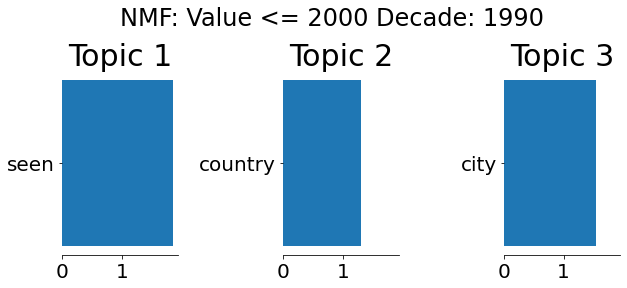

sample of each topic: (Dr. Thomas Starzl reads the clue.)  In 1992 my team transplanted a liver from one of these primates into a man
sample of each topic: He's the large & goofy title TV superhero seen here   "Probably that one. The balcony..."
sample of each topic: It springs to mind that there's a Florida city named for this game fish seen here


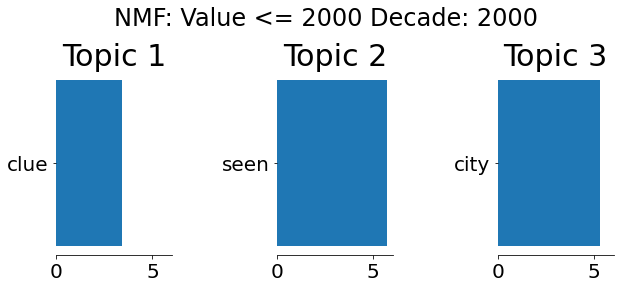

sample of each topic: Michael Cunningham's "The Hours" was inspired by this novel that Woolf originally called "The Hours"
sample of each topic: Kayak is an example of this, a word that reads the same forwards & backwards
sample of each topic: The vase seen here is made from this semiprecious stone


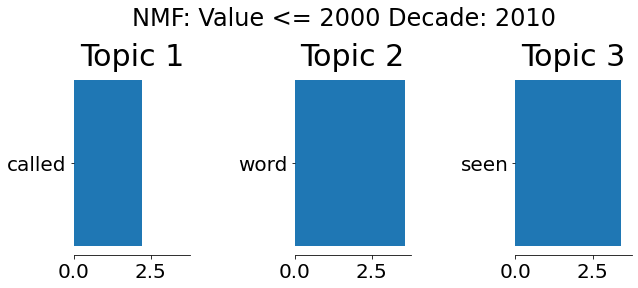

In [342]:
for grp in ['Value <= 500', 'Value <= 1000', 'Value <= 1500', 'Value <= 2000']:
    for decade in sorted(df.decade.unique()):
        round_year_plot(df, decade, grp)

## Question 2) b) Trends

### For the 500 or less categories each year consistently sees city as a top category
- This trend suggests geography and trivia about areas is most common

### Some Questions include:
- (1980s) Founder of the nursing profession, she was named after the ***city*** in which she was born
- (2000s) The ***city*** of Yuma in this state has a record average of 4,055 hours of sunshine each year

### For the greater than 500 but less than or equal to 1000 categories each year consistently sees "country", "type", and "city" as top categories
- This trend suggests geography and trivia about regions is most common

### Some Questions include:
- (1990s) In February 1904 this ***country*** attacked the Russian fleet at Port Arthur
- (2000s) This second-largest Alaskan ***city*** wasn't named for an actor
- (2010s) It's a ***type*** of bounce house, or a dance made famous by Michael Jackson

### For the greater than 1000 but less than or equal to 1500 categories each year consistently sees "seen" as a top category
- This trend suggests harder questions rely more on visual cues

### Some Questions include:
- (2000s) Future leader of the UK ***seen*** here on the right in the 1880s
- (2010s) This dog breed ***seen*** here is a loyal and protective companion

### For the greater than 1500 but less than or equal 2000 categories each year consistently sees "seen" and "city" as a top categories
- This trend suggests top tier questions rely more on visual cues plus geography trivia

### Some Questions include:
- (1980s) 1 of 3 Major League Baseball teams with state rather than ***city*** names
- (2010s) The vase ***seen*** here is made from this semiprecious stone

### 2) b) conclusion
- Winning Jeopardy seems to rely heavily on geographical knowledge and trivia
- As well, learning faces and images associated with whatever trivia you are memorizing is critical to win